In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f9c877695e0>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f9c87775070>,
 'id': 1,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'elevation': 3.0,
 'latitude': 21.2716}

In [13]:
#most recent date - using an order by for date, descending order, getting the first result back
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [18]:
#finding a year before the most recent date
year_before = (dt.date(2017, 8, 23) - dt.timedelta(days=365)).strftime('%Y-%m-%d')
year_before

'2016-08-23'

In [47]:
#getting precipitation data for last 12 months in dataset
sel = [Measurement.prcp, Measurement.date, Measurement.id, Measurement.tobs, Measurement.station]
precip_data = session.query(*sel).filter(Measurement.date >= year_before).all()

In [48]:
#making lists of dates and precipitation info
dates = [x[1] for x in precip_data]
precips = [x[0] for x in precip_data]

In [51]:
#creating df out of dates and precipitation lists
#setting index as date
#grouping by date
prcp_data = pd.DataFrame({'date': dates, 'precipitation': precips}).set_index('date').groupby('date')
prcp_data.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


/Users/sarahdalleyhood/~Applications/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


date
2016-08-23    AxesSubplot(0.08,0.07;0.87x0.81)
2016-08-24    AxesSubplot(0.08,0.07;0.87x0.81)
2016-08-25    AxesSubplot(0.08,0.07;0.87x0.81)
2016-08-26    AxesSubplot(0.08,0.07;0.87x0.81)
2016-08-27    AxesSubplot(0.08,0.07;0.87x0.81)
                            ...               
2017-08-19    AxesSubplot(0.08,0.07;0.87x0.81)
2017-08-20    AxesSubplot(0.08,0.07;0.87x0.81)
2017-08-21    AxesSubplot(0.08,0.07;0.87x0.81)
2017-08-22    AxesSubplot(0.08,0.07;0.87x0.81)
2017-08-23    AxesSubplot(0.08,0.07;0.87x0.81)
Length: 366, dtype: object

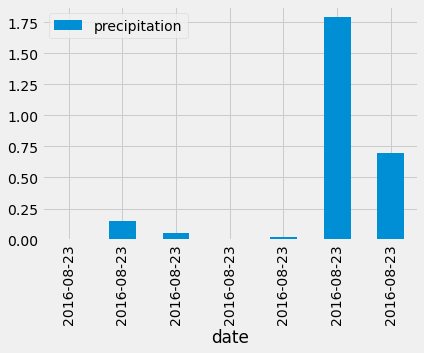

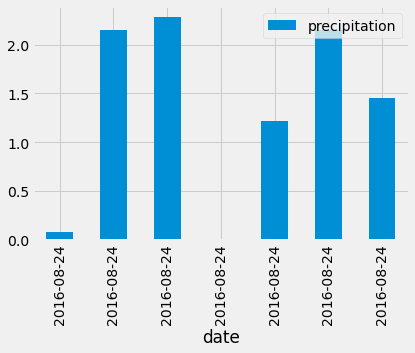

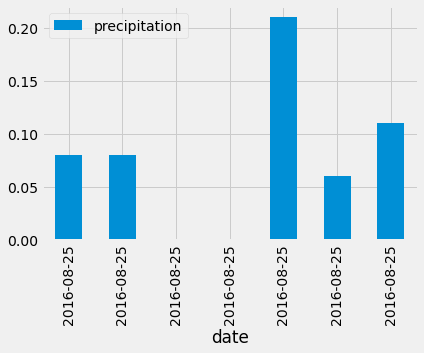

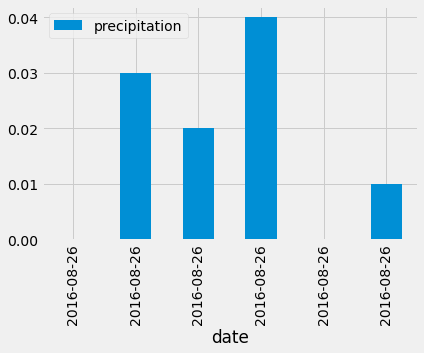

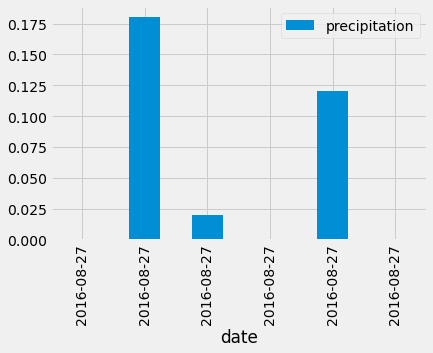

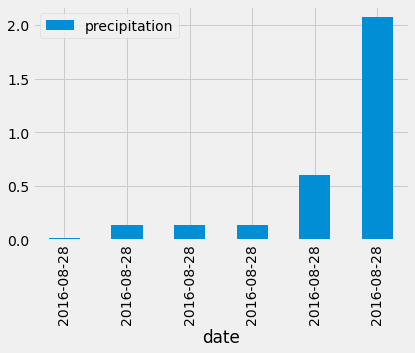

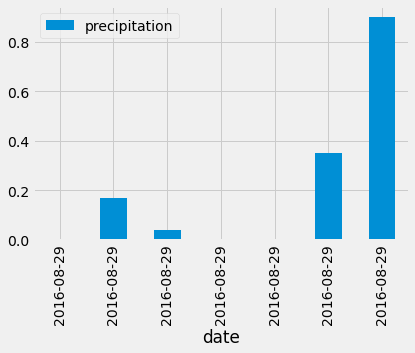

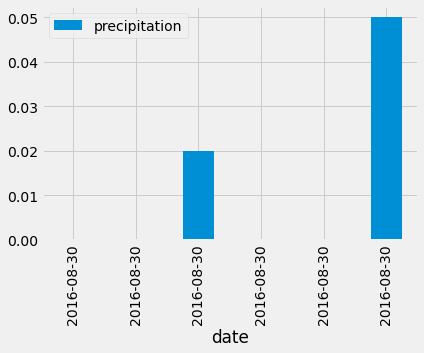

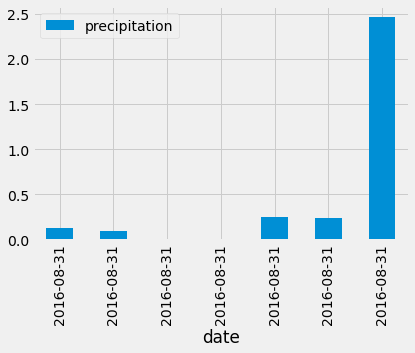

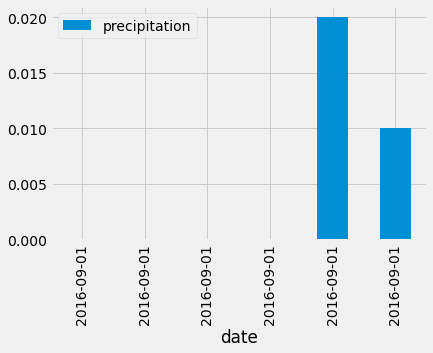

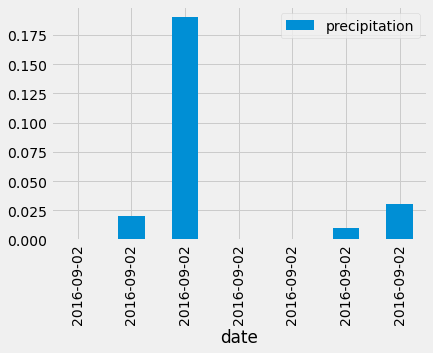

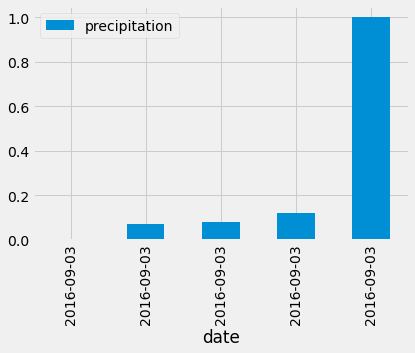

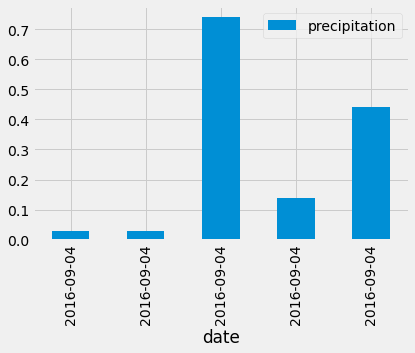

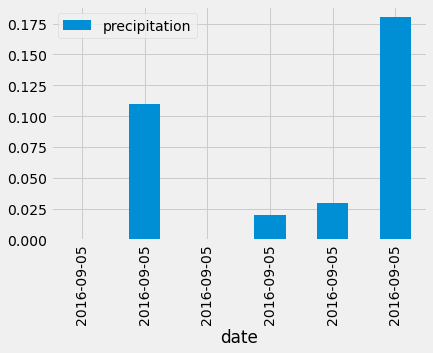

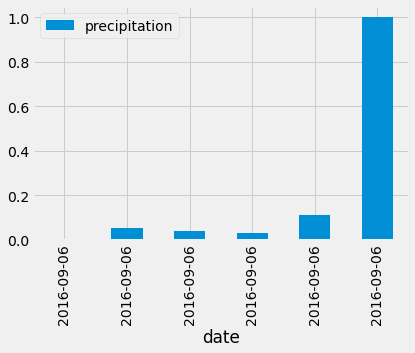

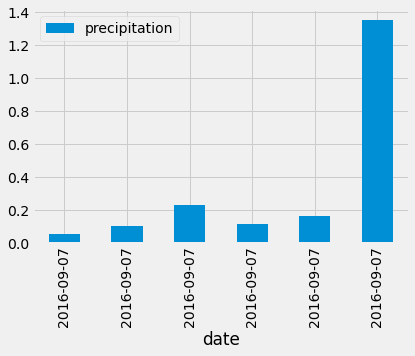

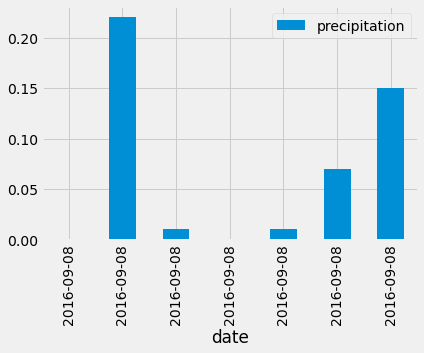

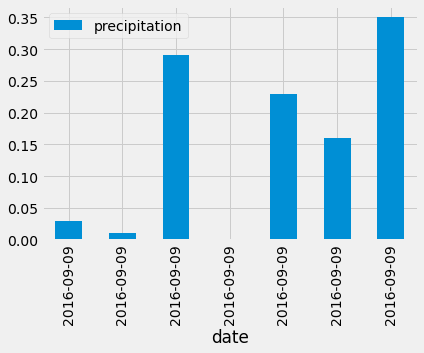

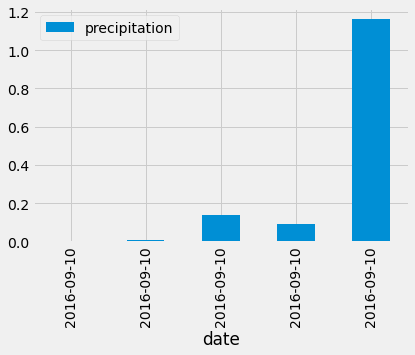

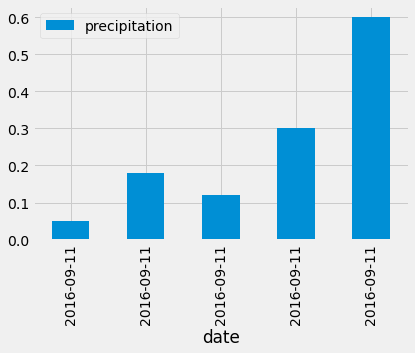

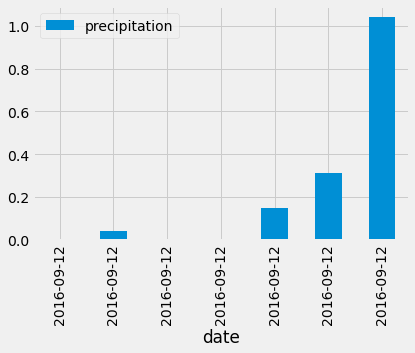

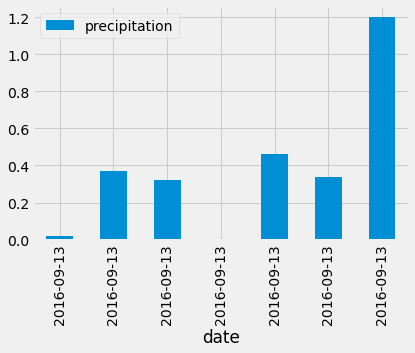

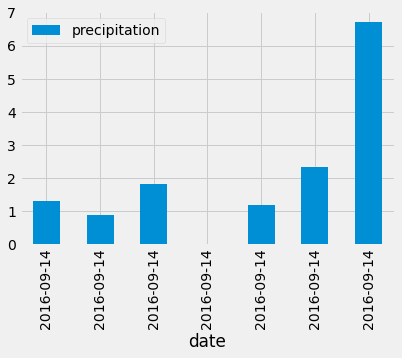

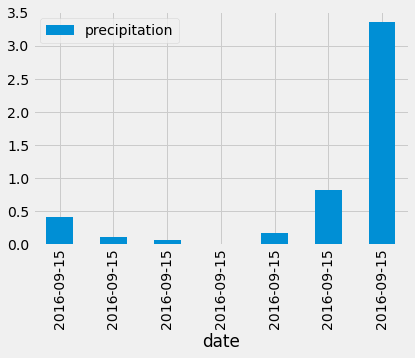

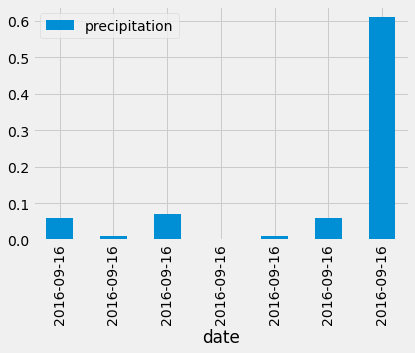

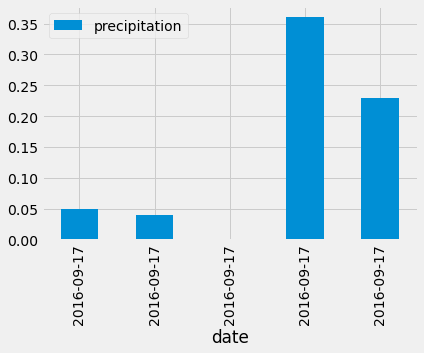

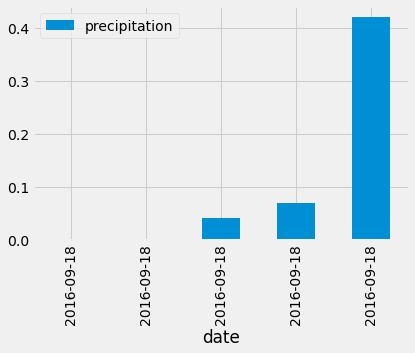

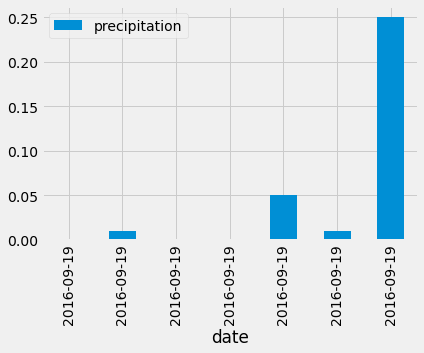

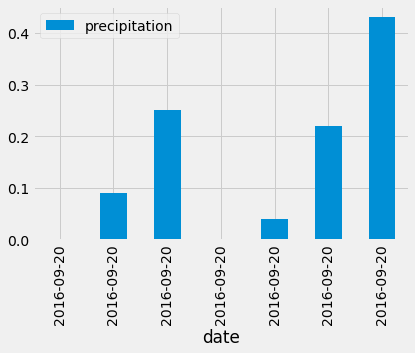

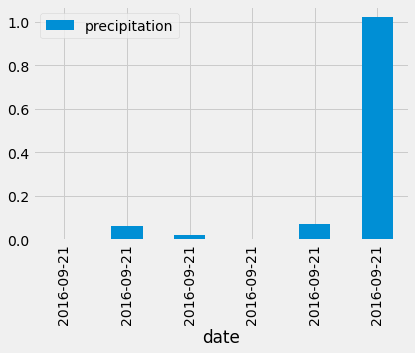

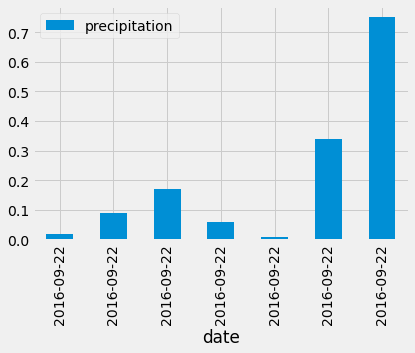

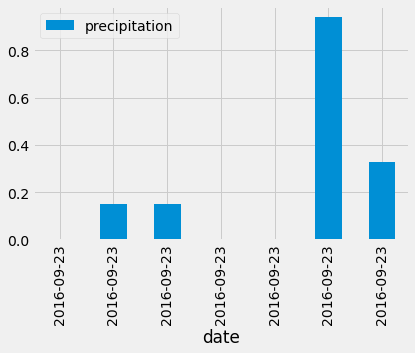

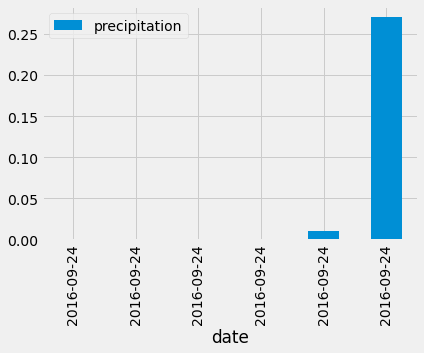

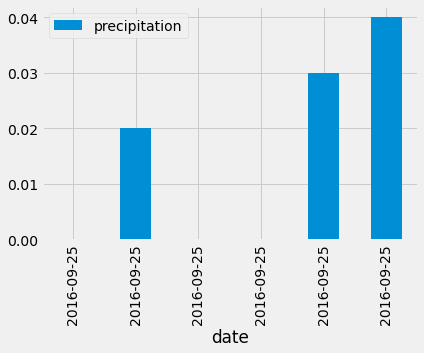

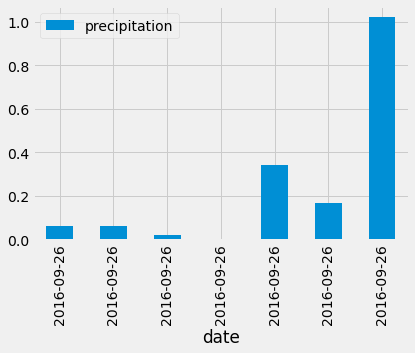

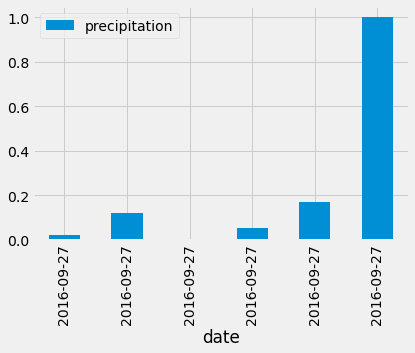

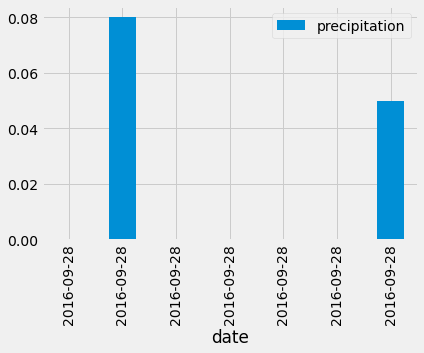

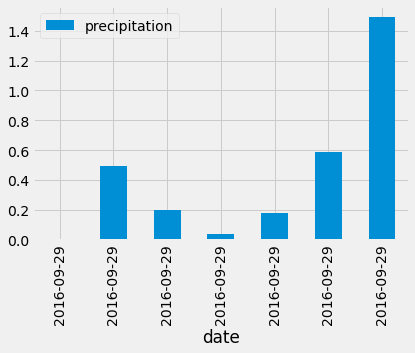

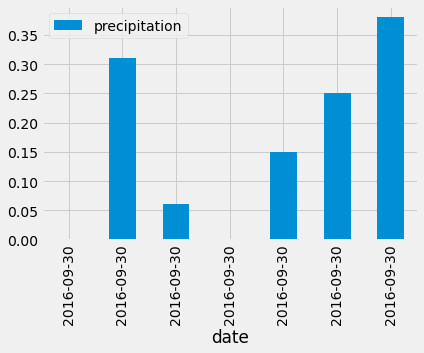

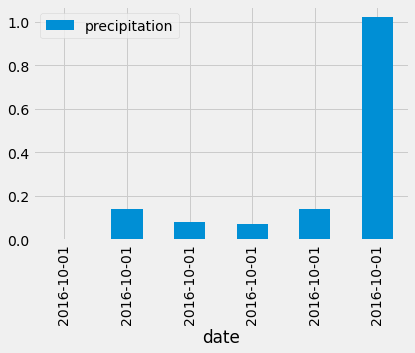

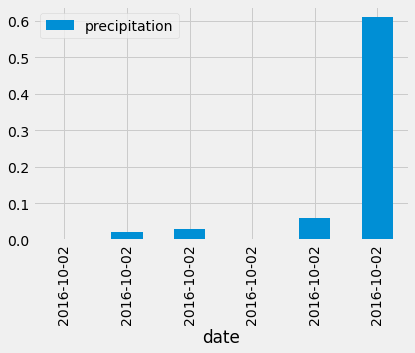

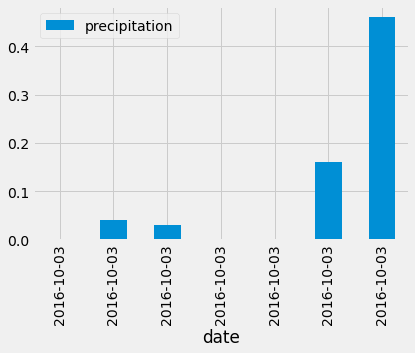

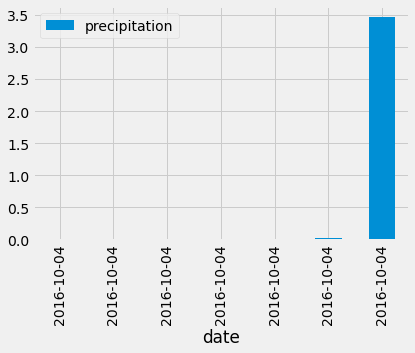

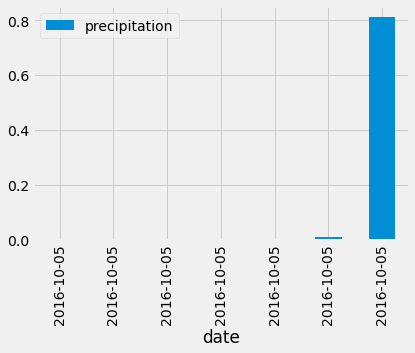

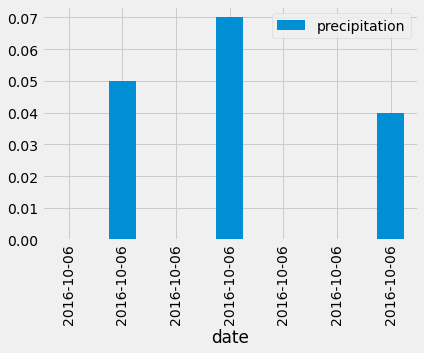

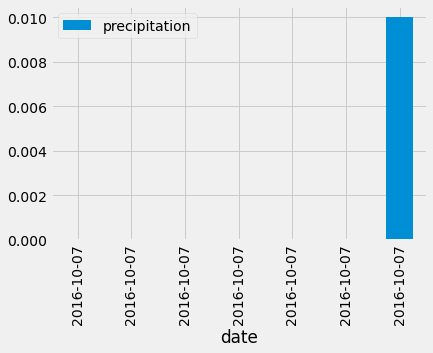

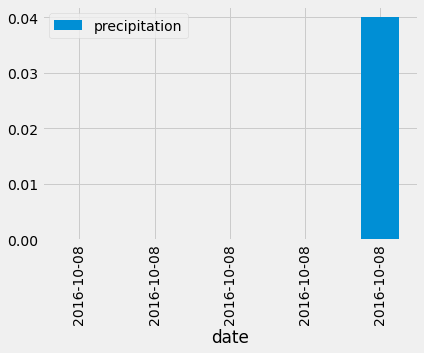

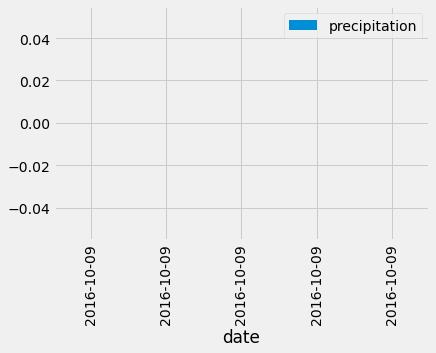

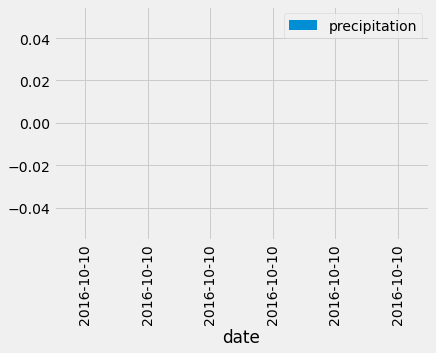

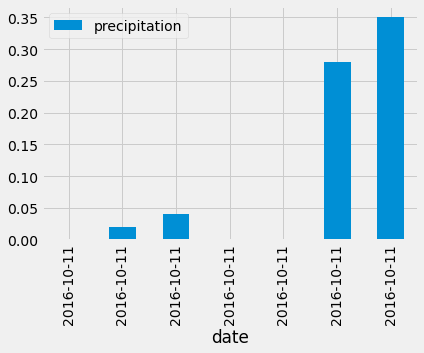

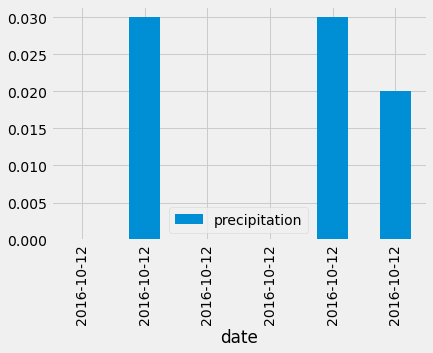

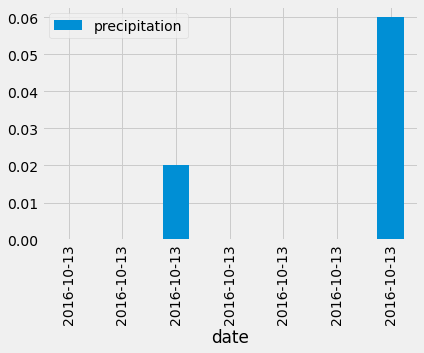

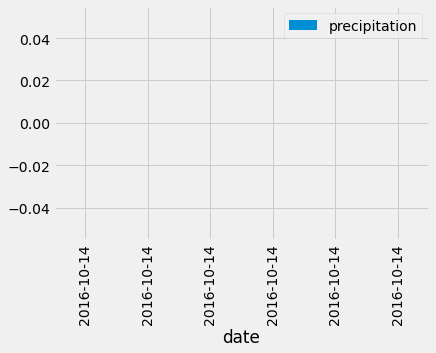

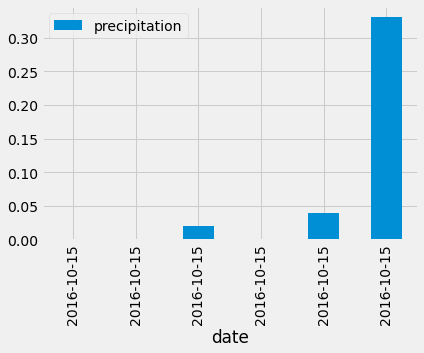

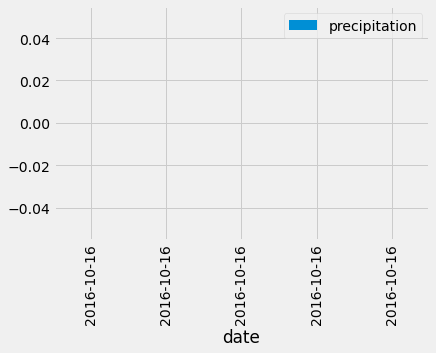

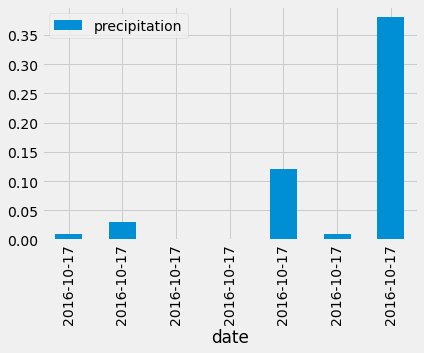

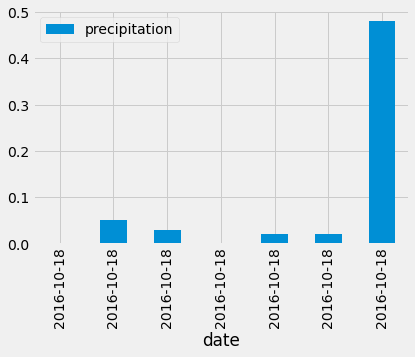

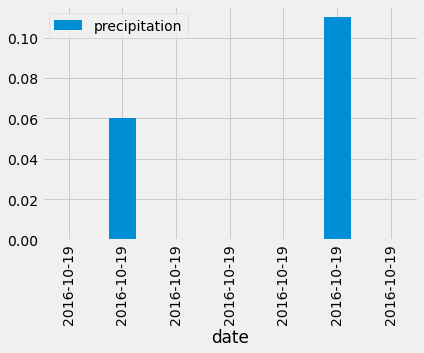

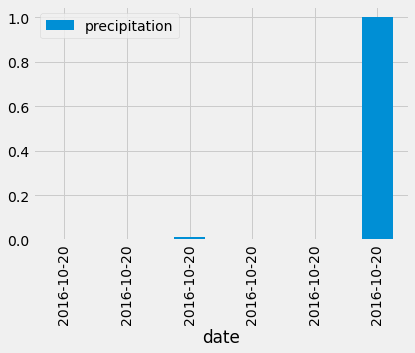

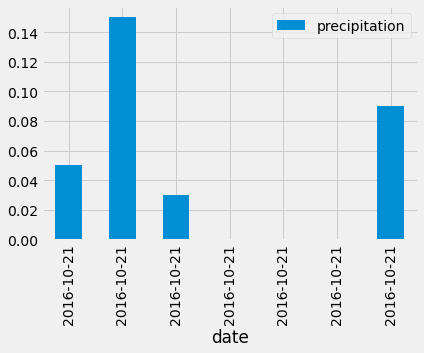

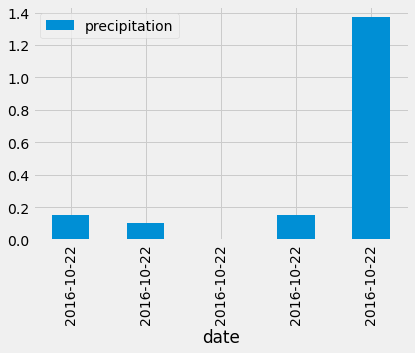

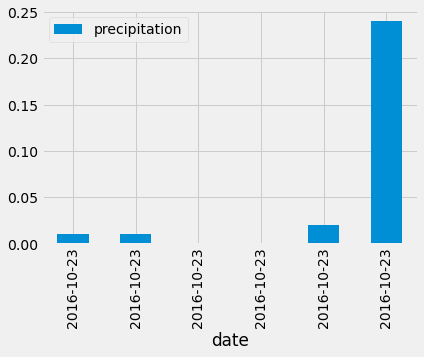

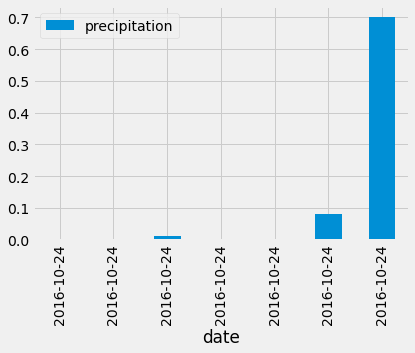

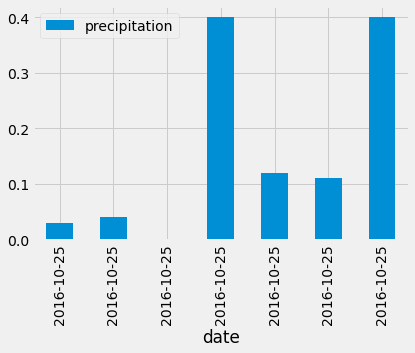

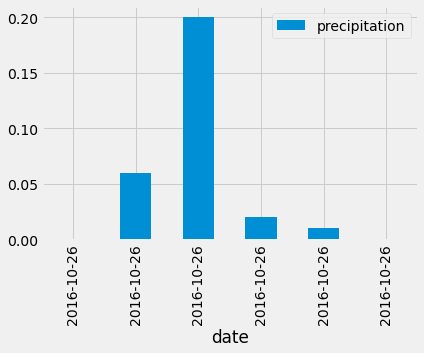

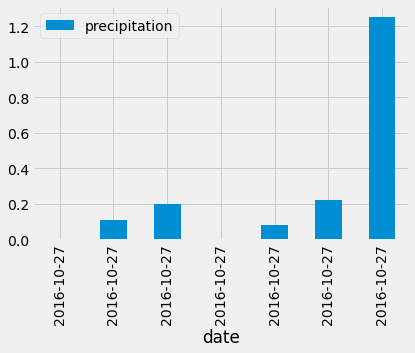

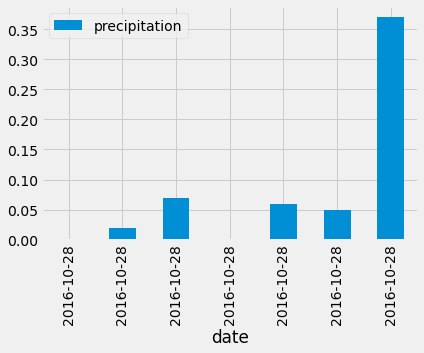

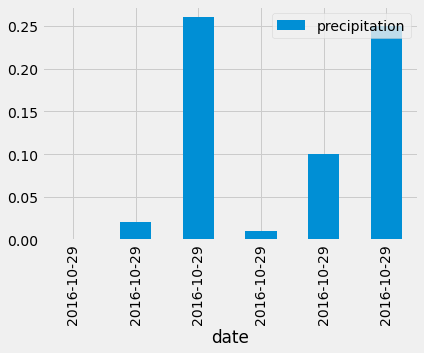

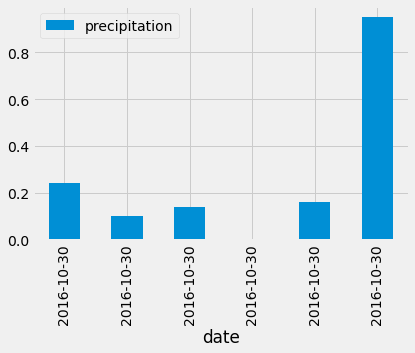

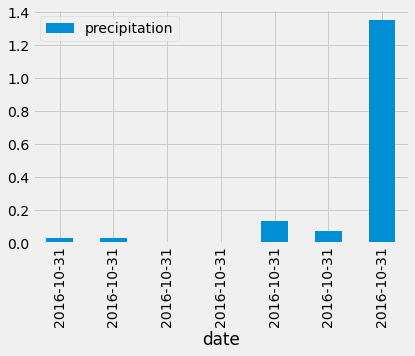

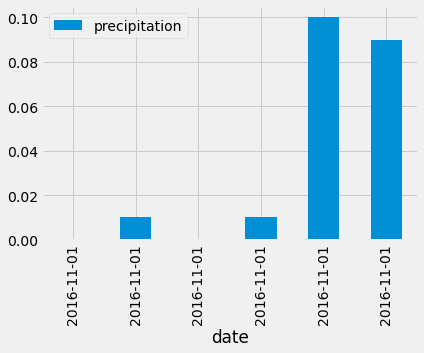

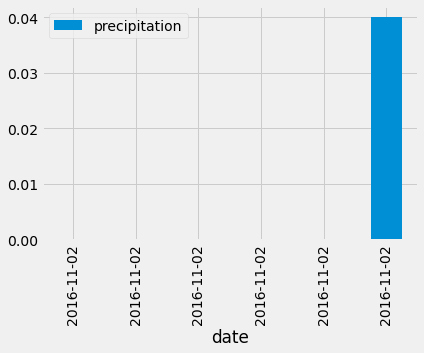

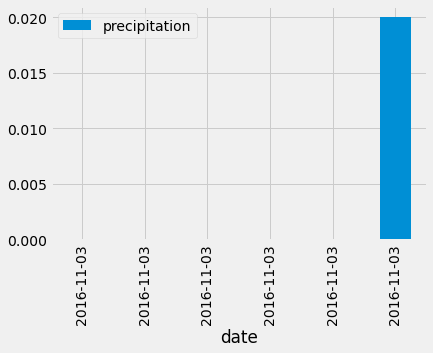

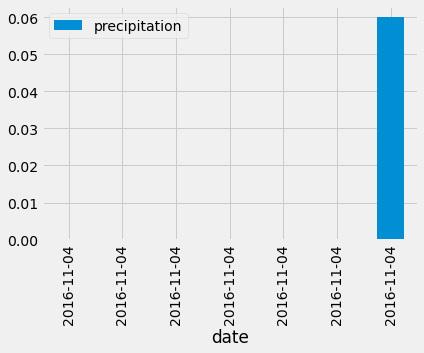

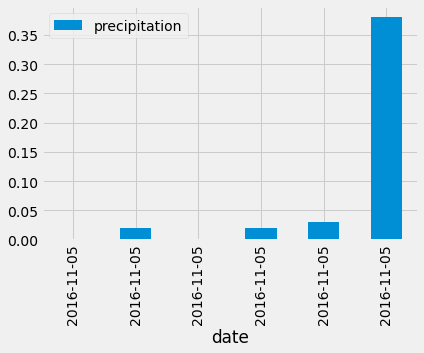

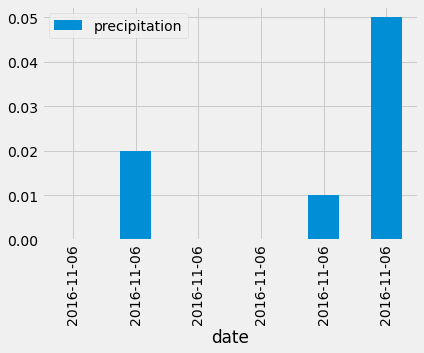

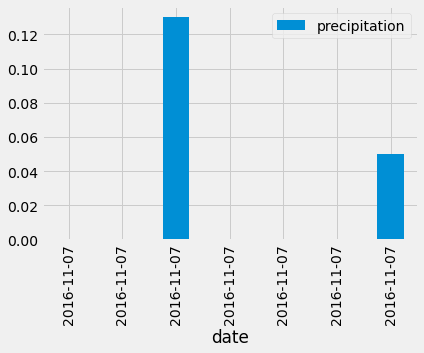

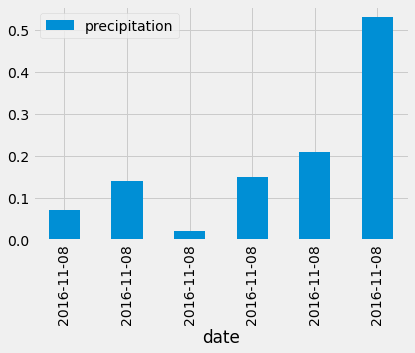

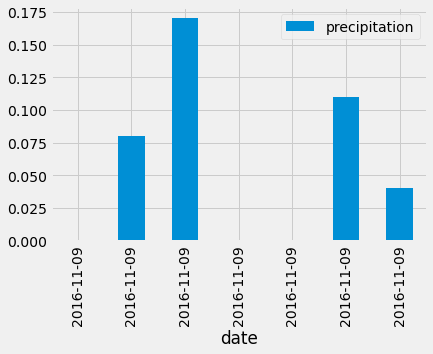

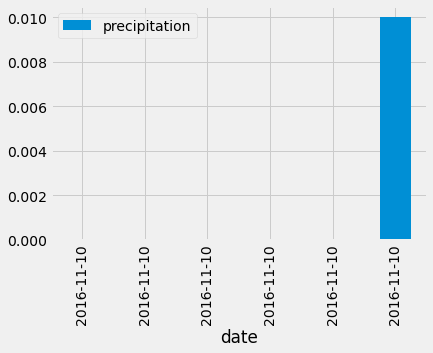

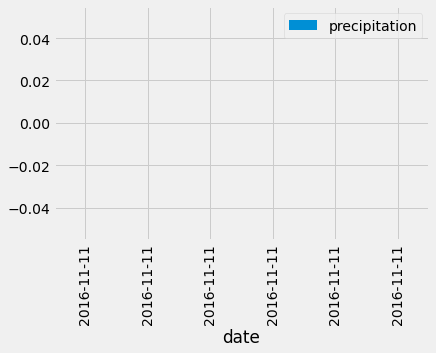

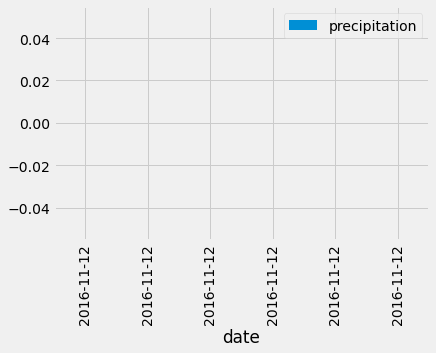

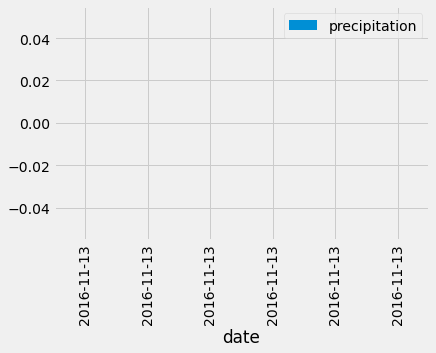

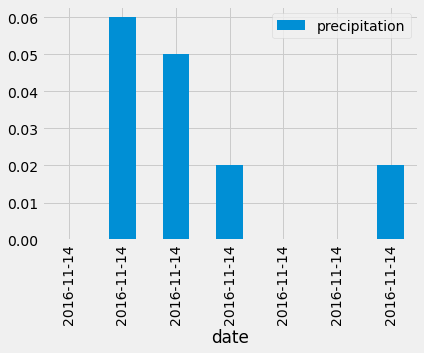

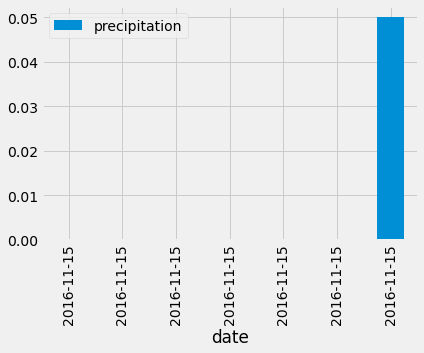

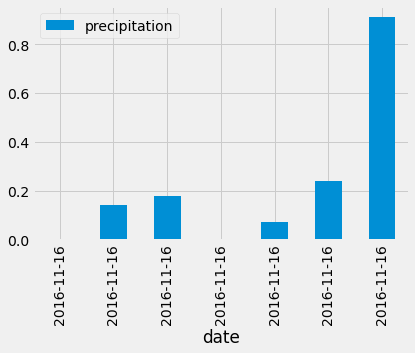

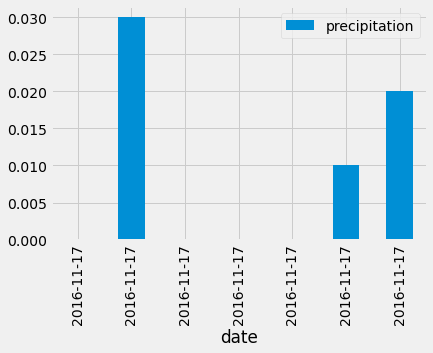

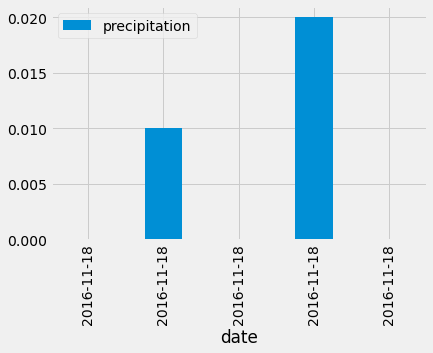

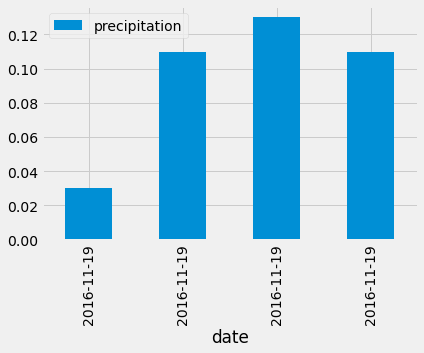

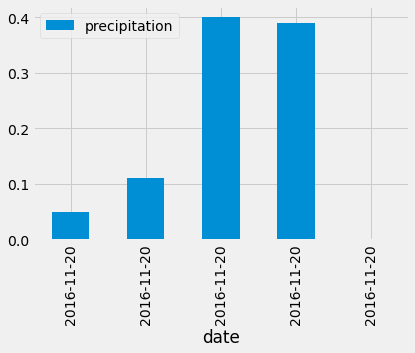

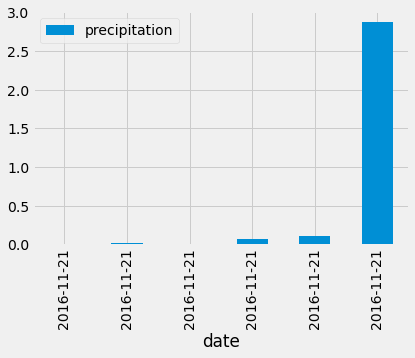

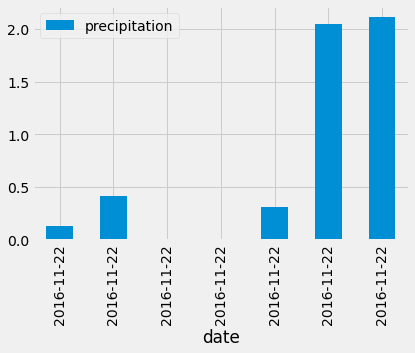

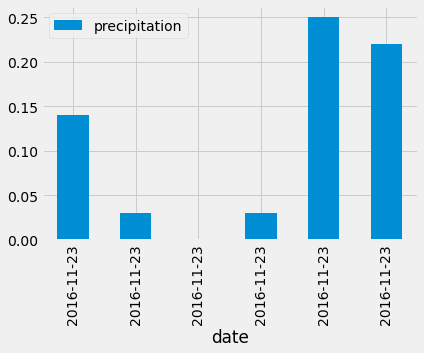

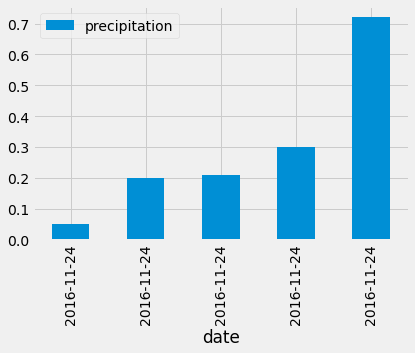

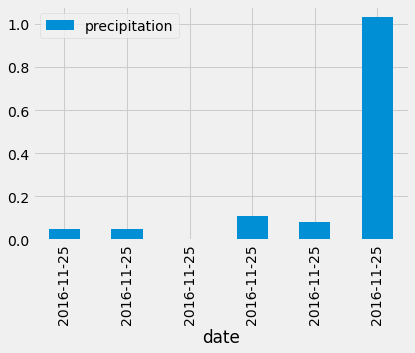

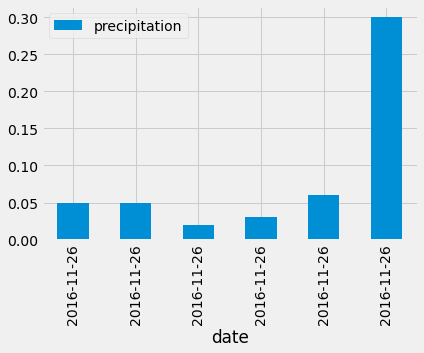

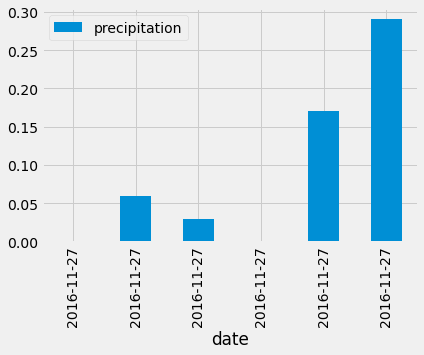

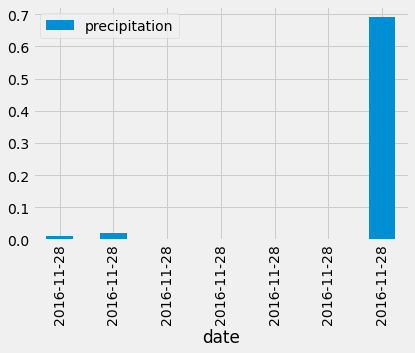

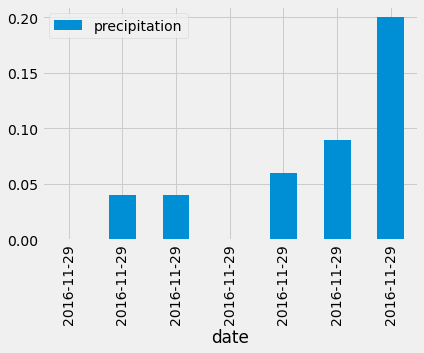

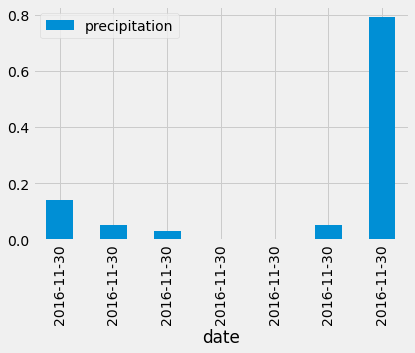

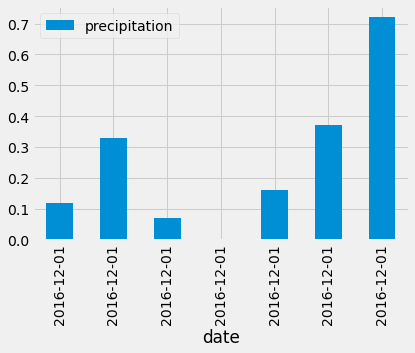

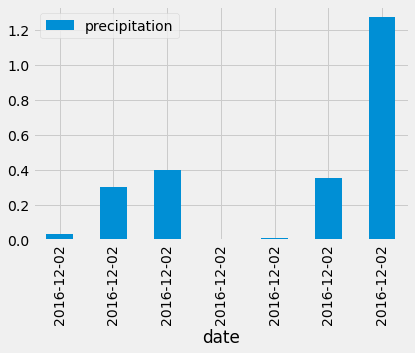

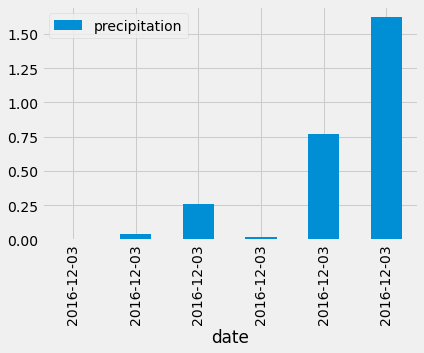

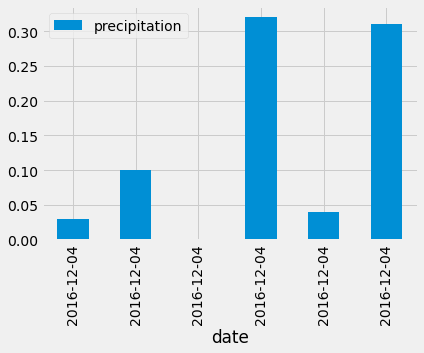

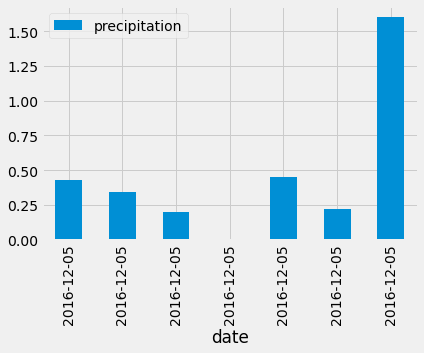

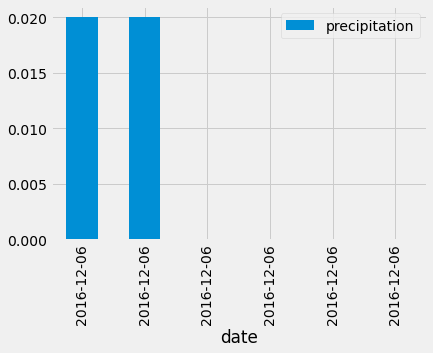

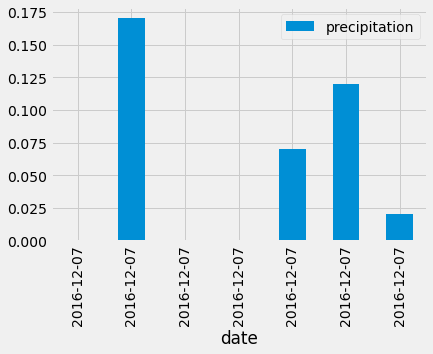

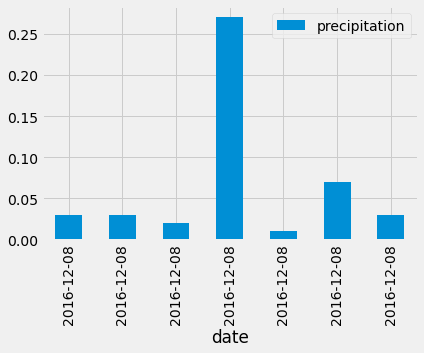

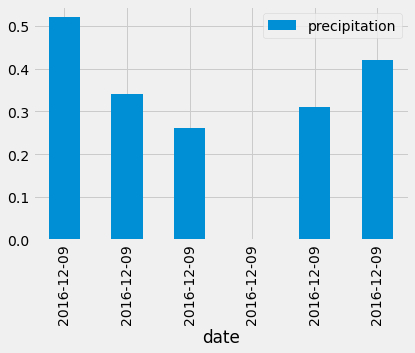

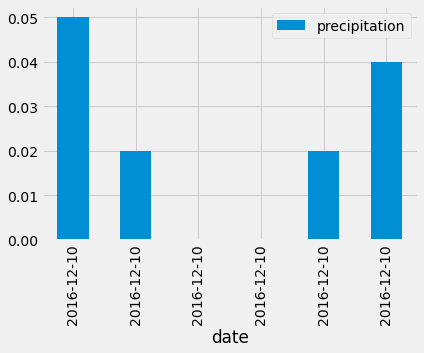

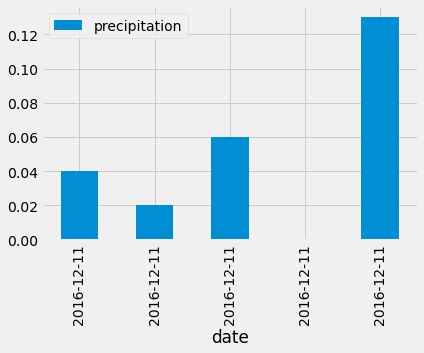

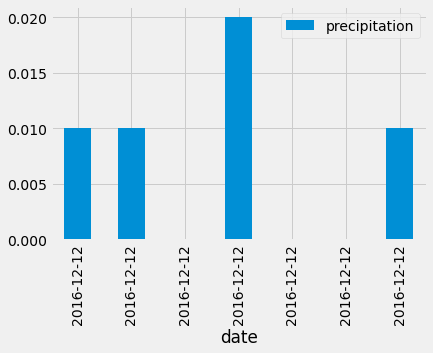

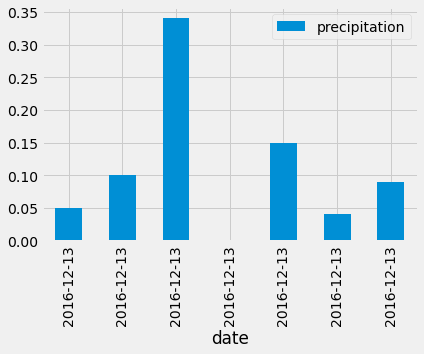

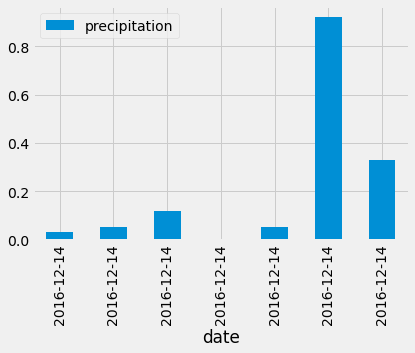

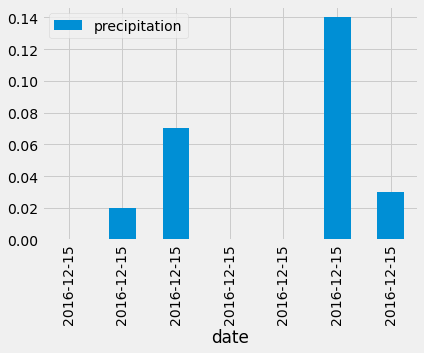

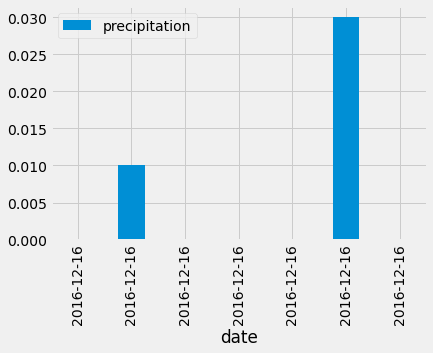

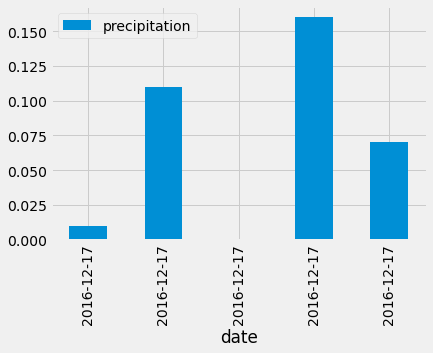

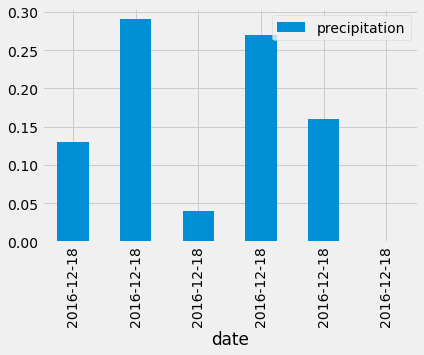

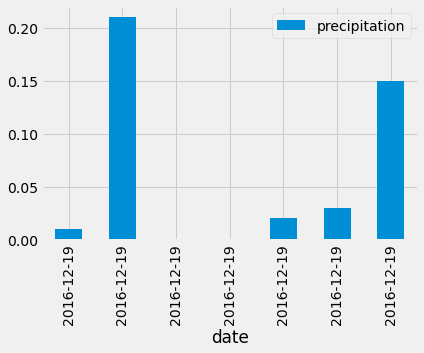

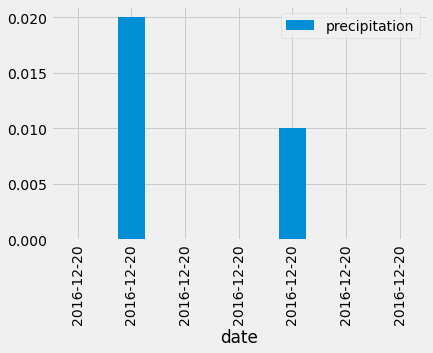

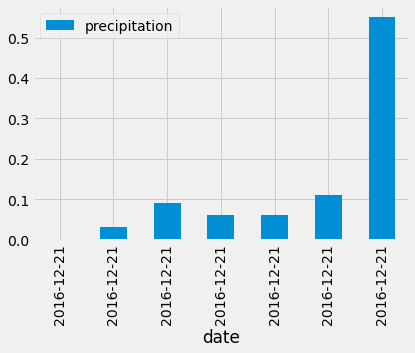

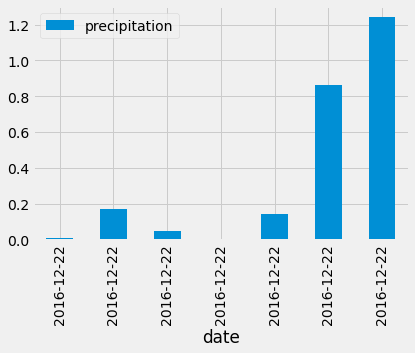

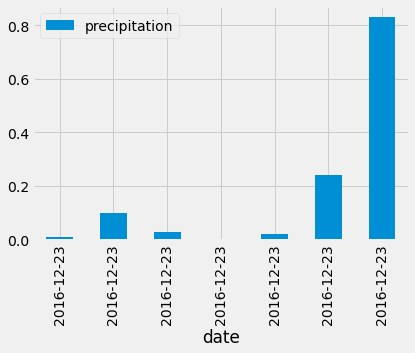

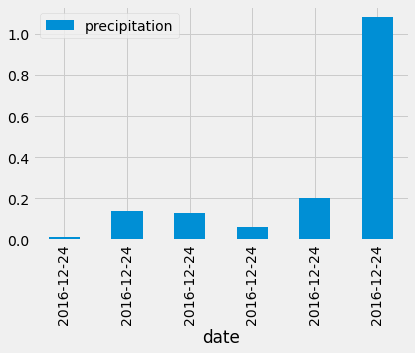

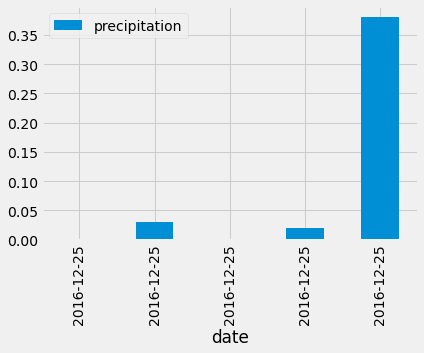

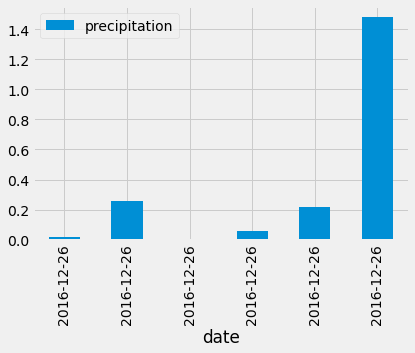

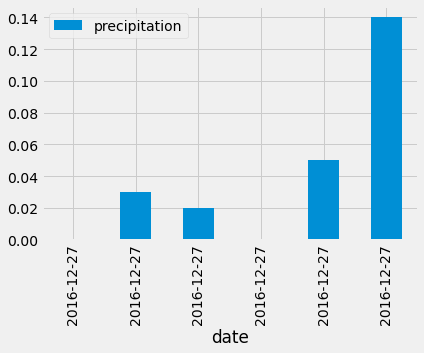

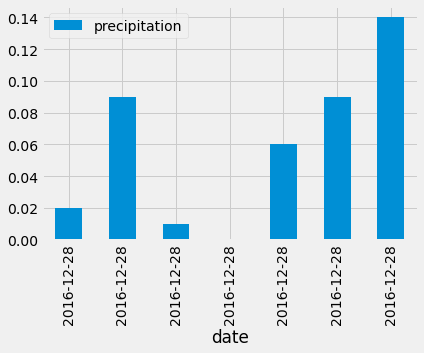

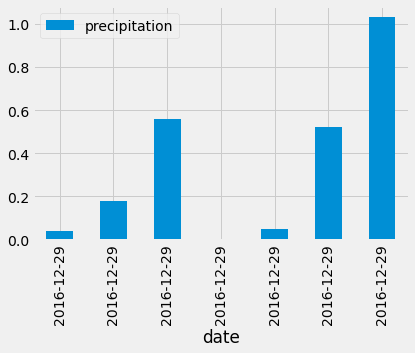

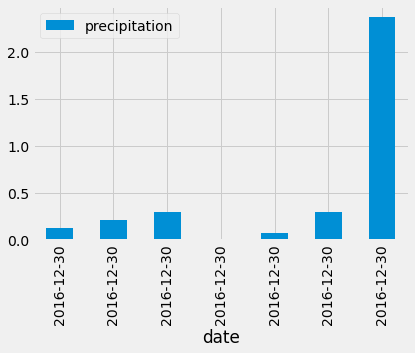

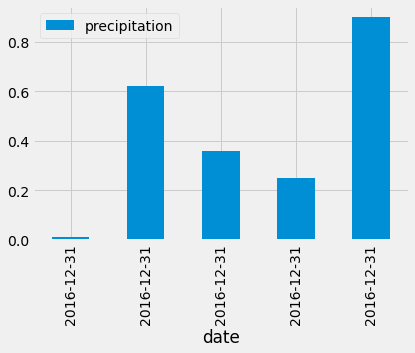

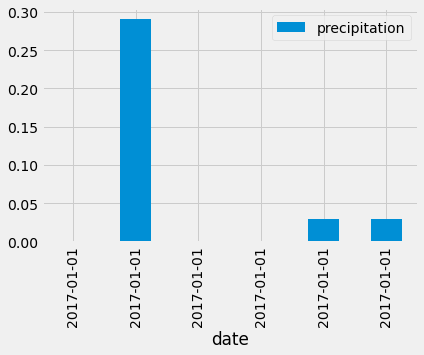

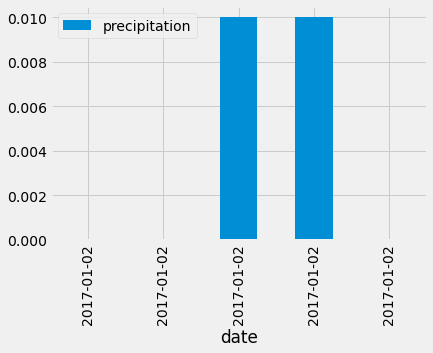

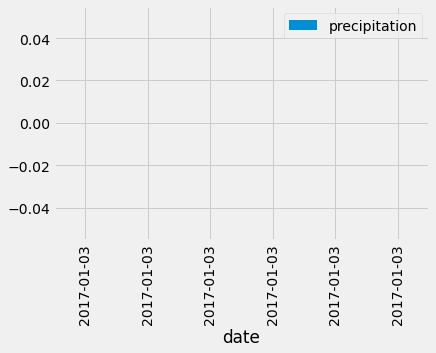

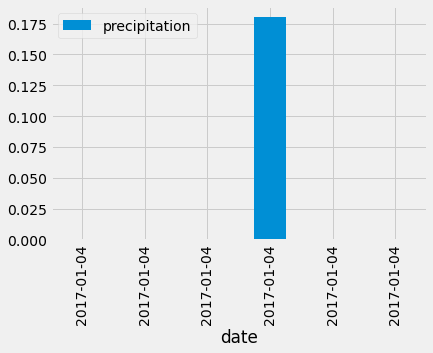

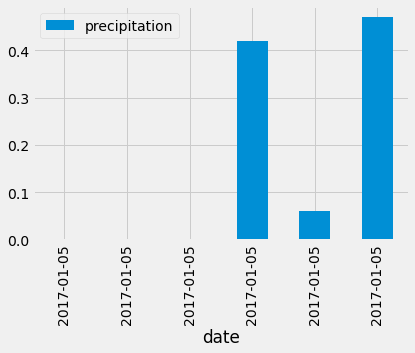

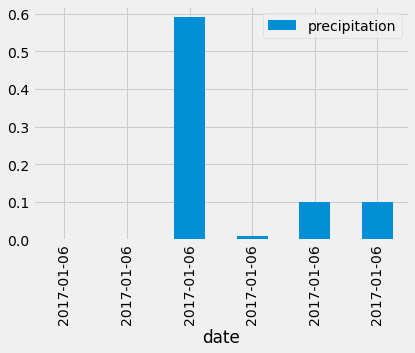

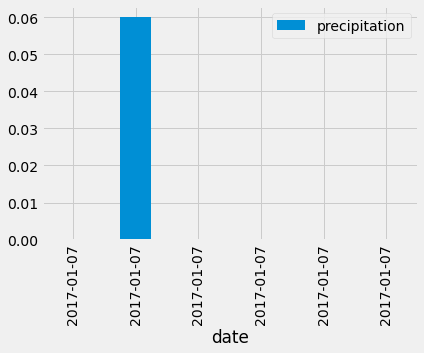

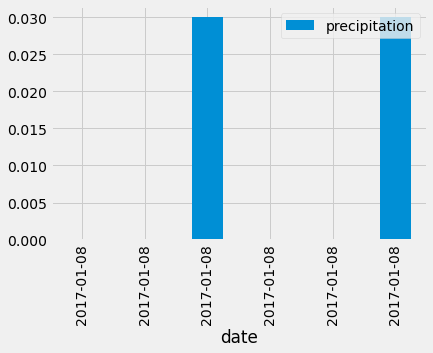

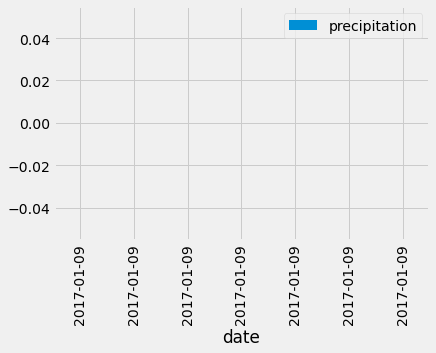

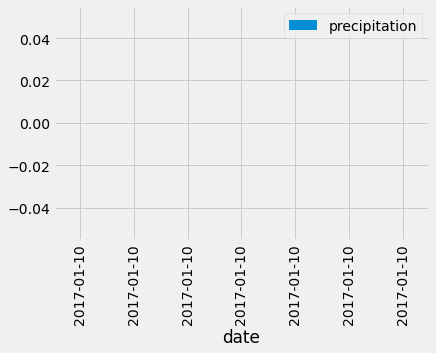

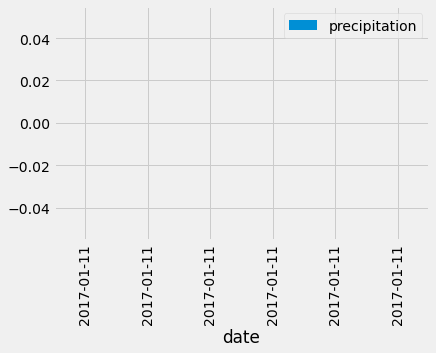

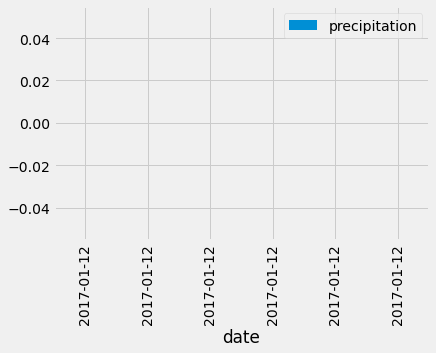

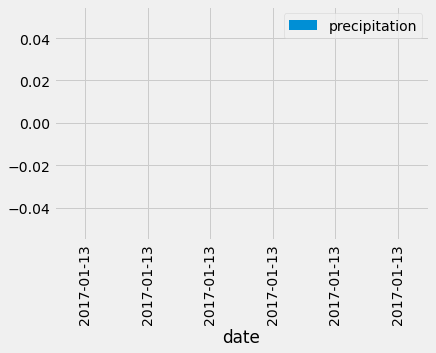

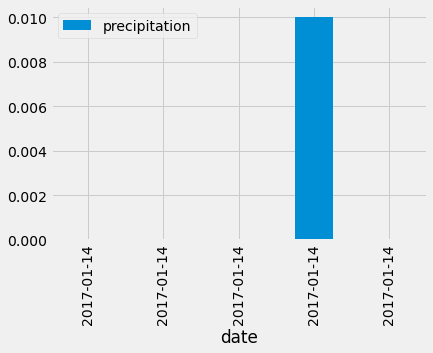

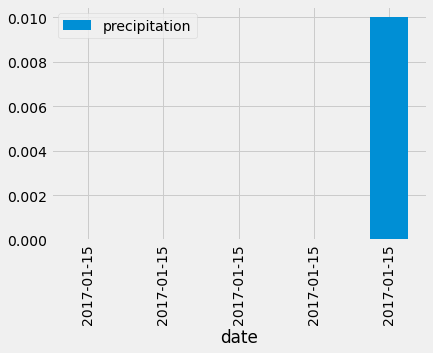

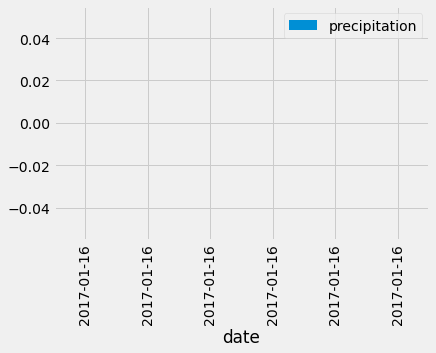

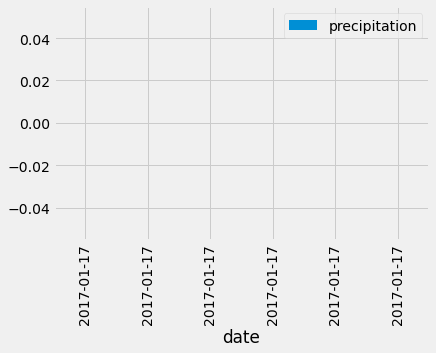

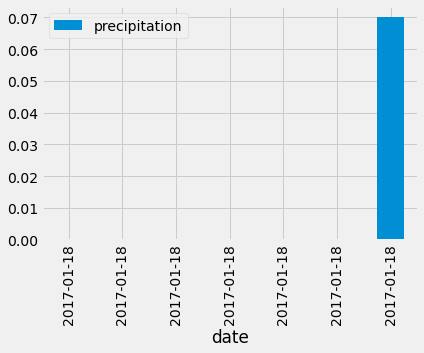

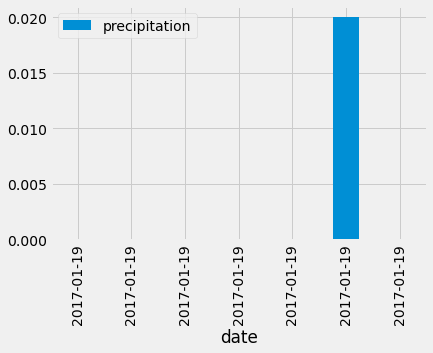

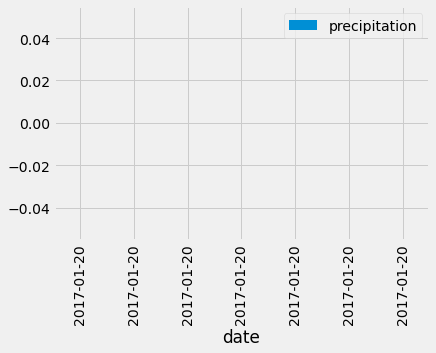

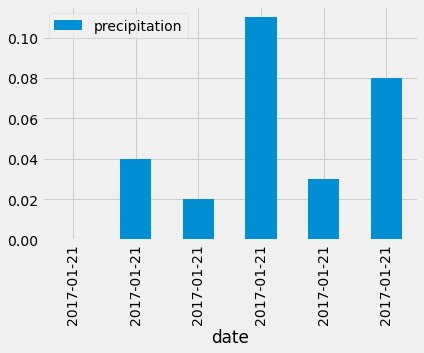

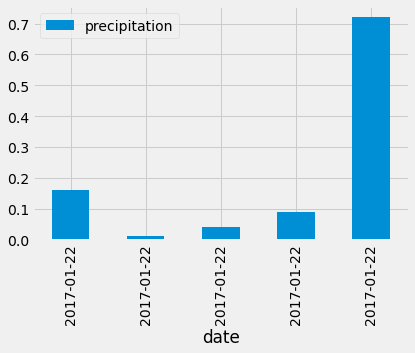

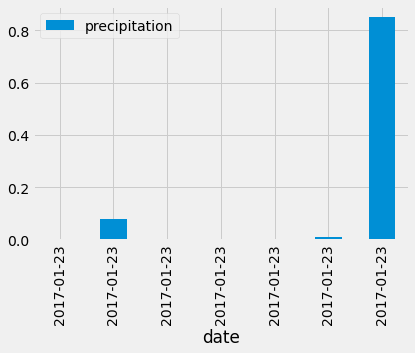

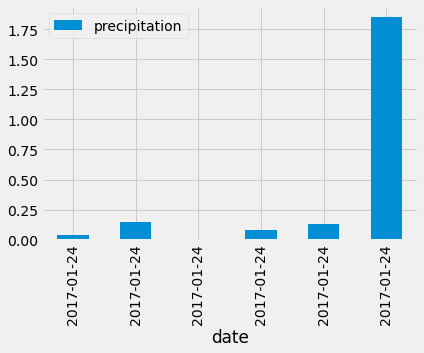

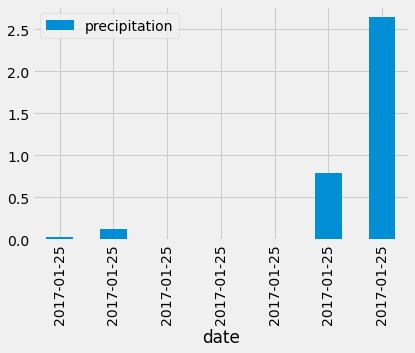

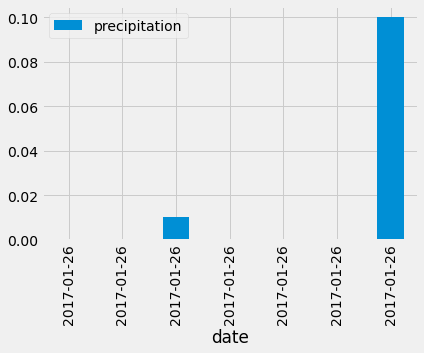

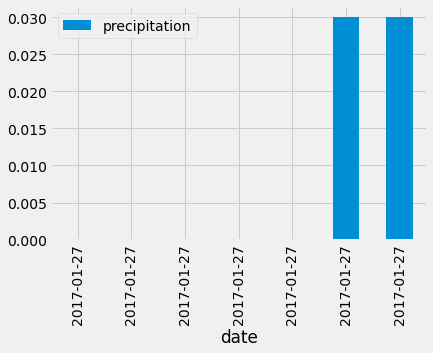

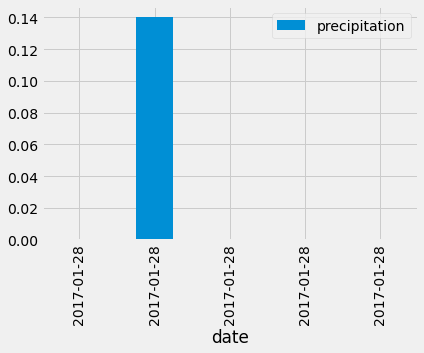

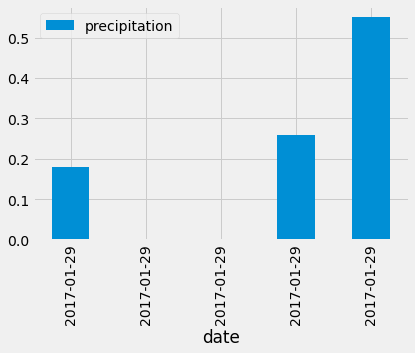

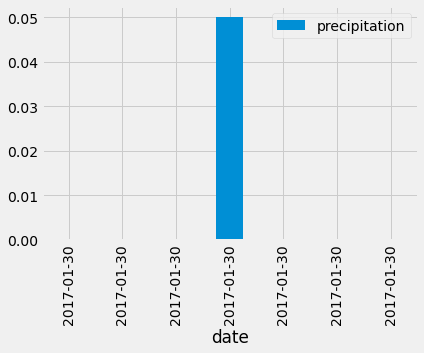

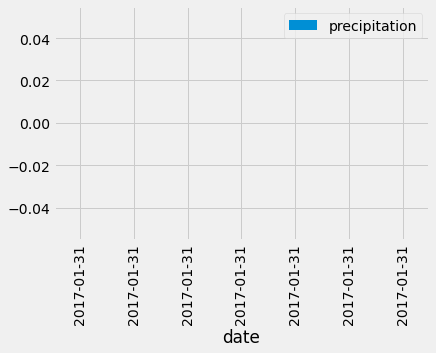

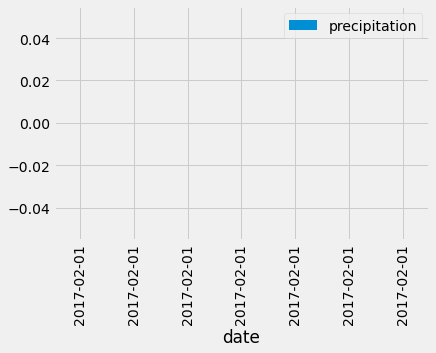

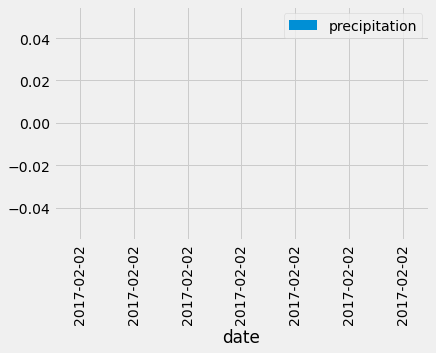

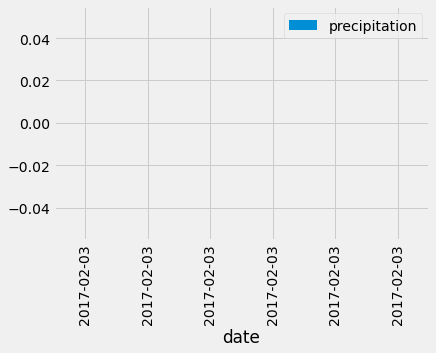

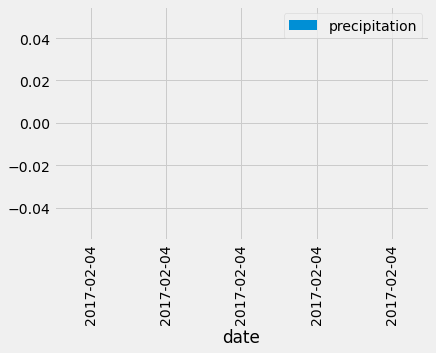

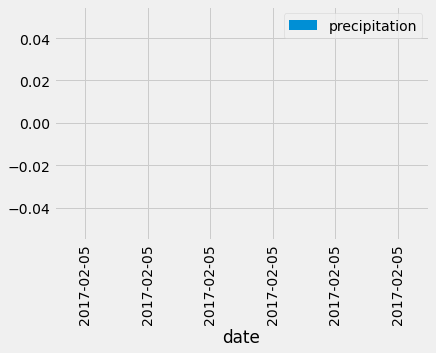

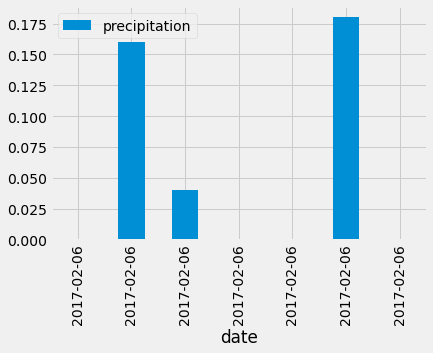

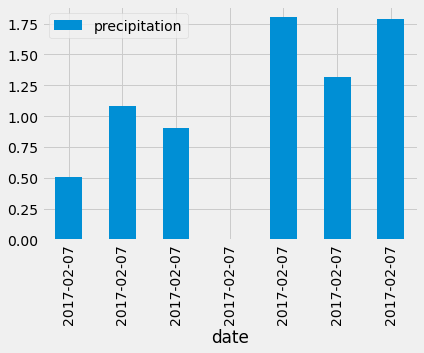

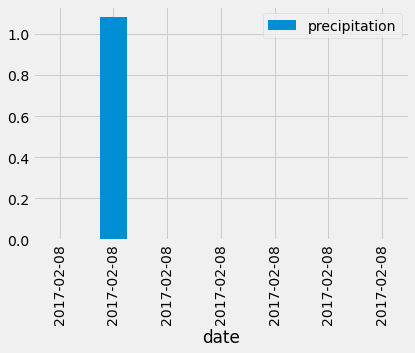

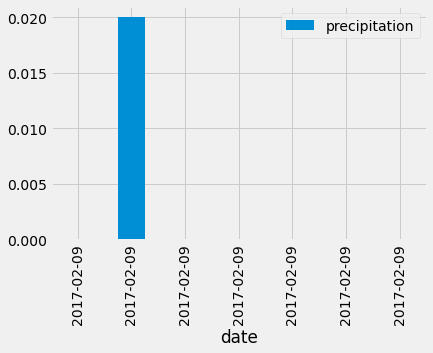

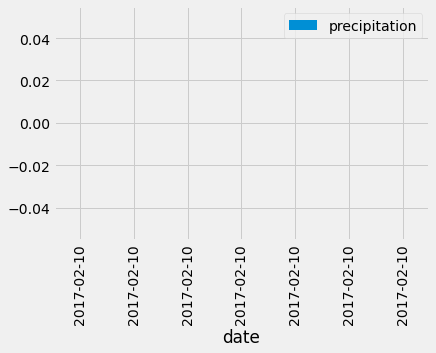

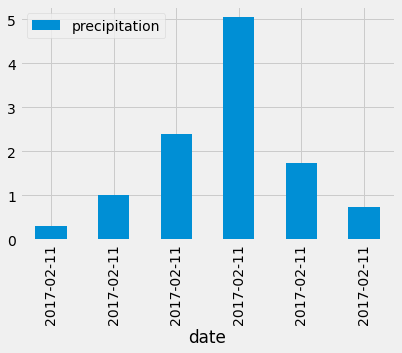

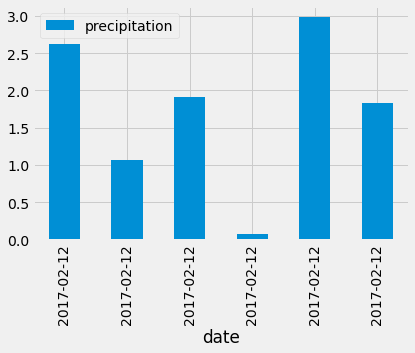

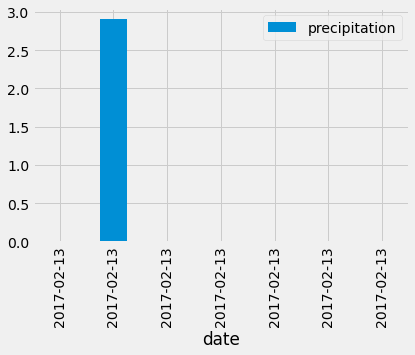

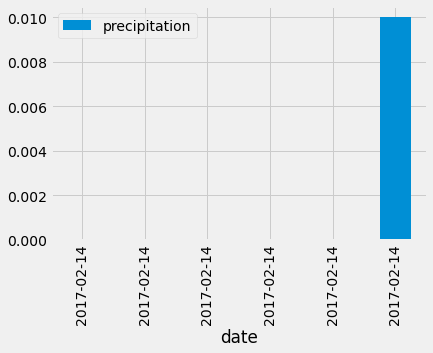

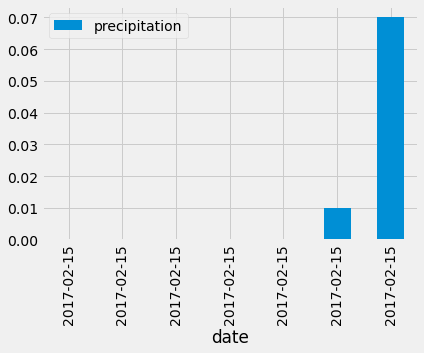

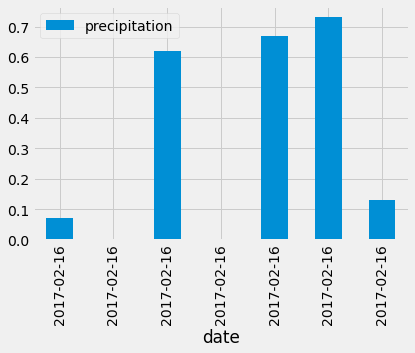

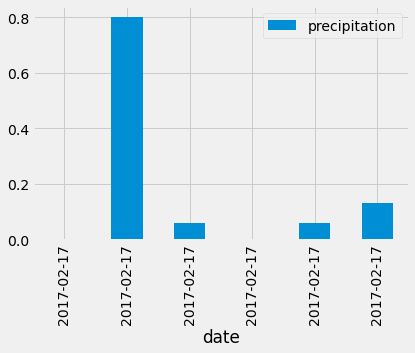

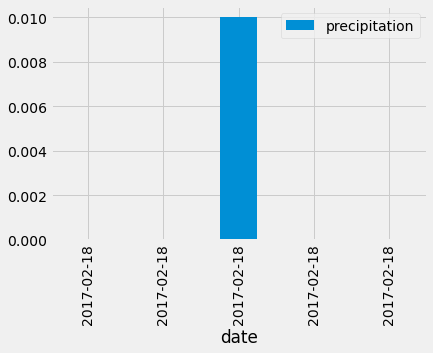

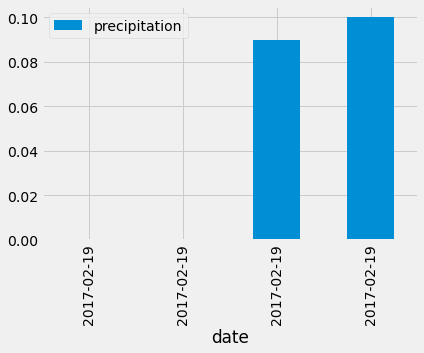

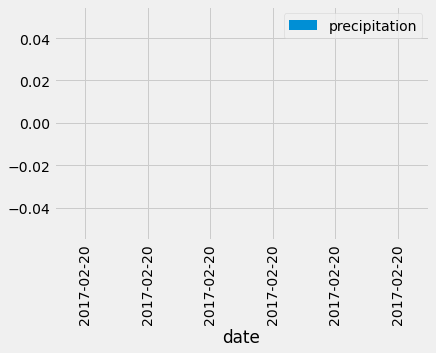

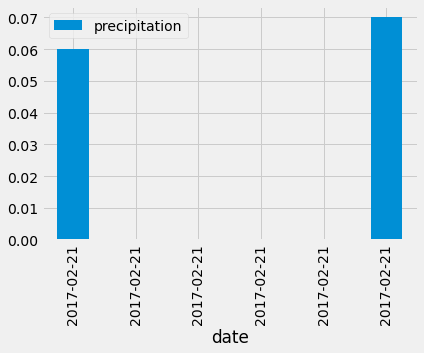

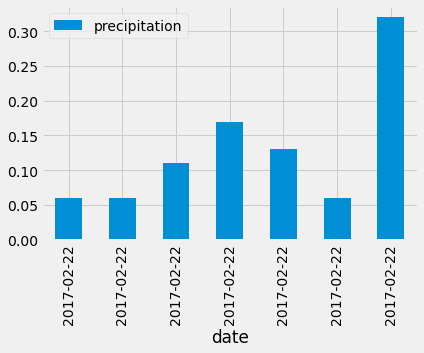

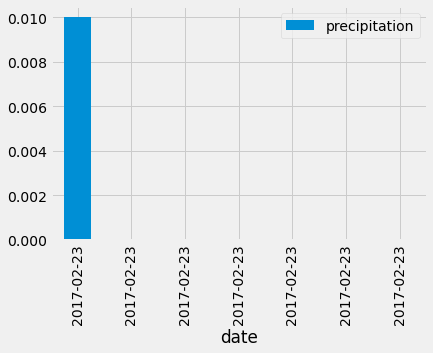

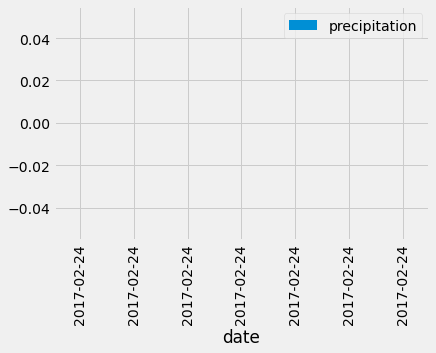

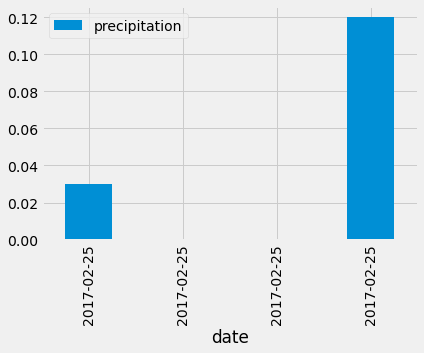

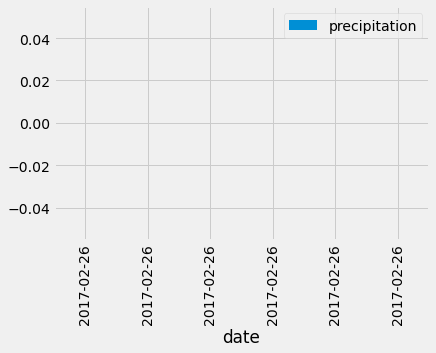

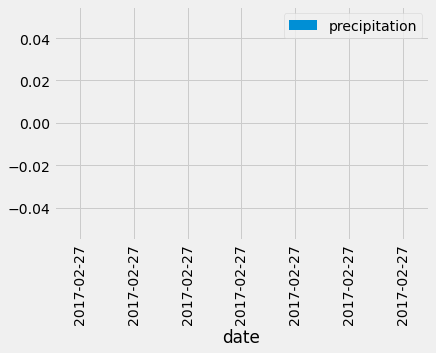

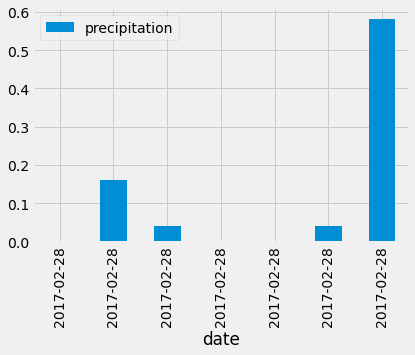

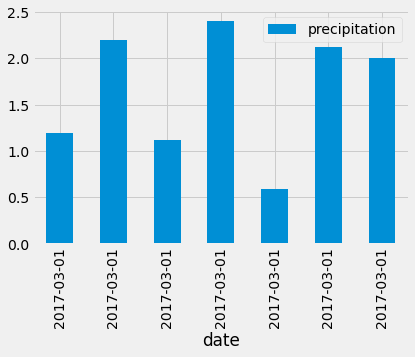

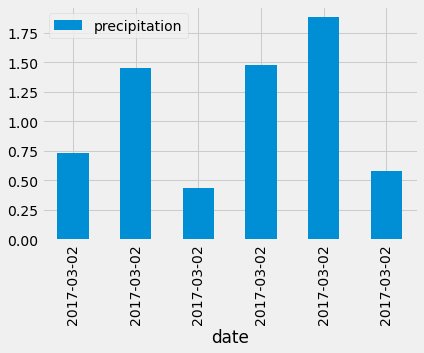

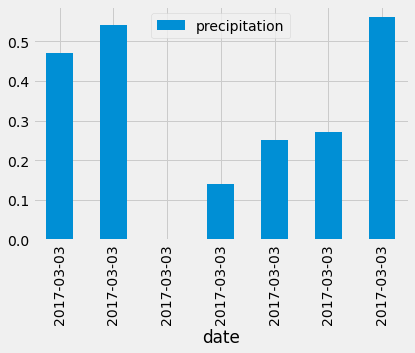

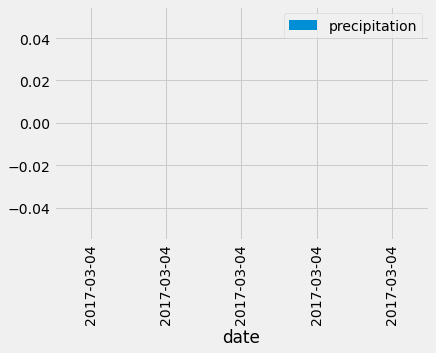

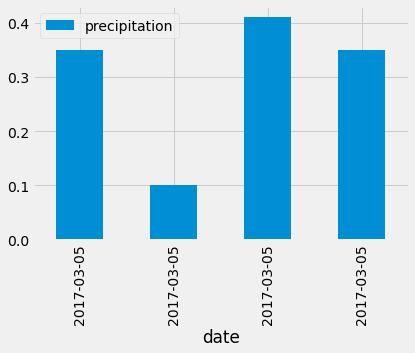

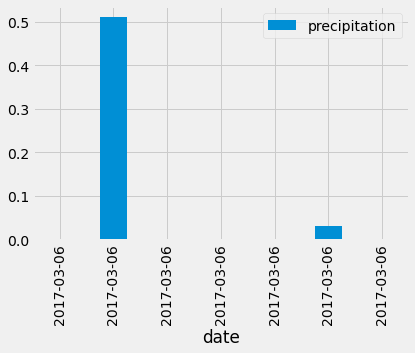

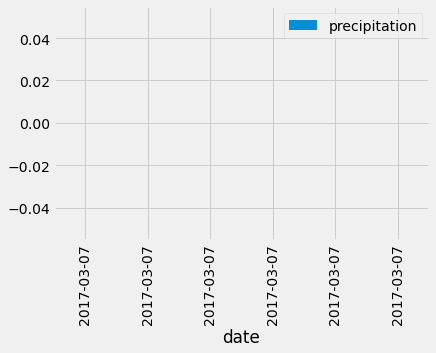

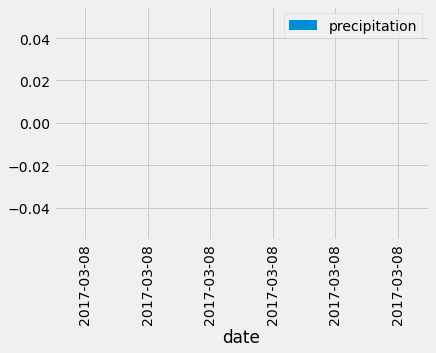

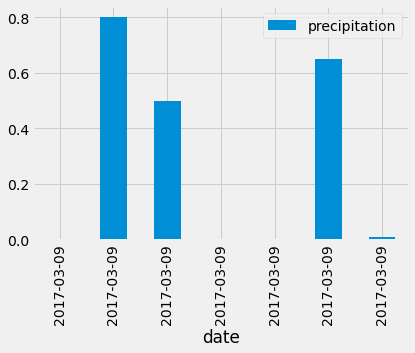

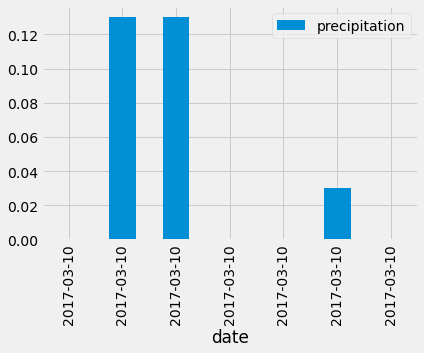

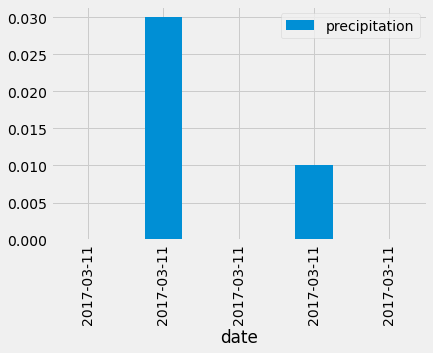

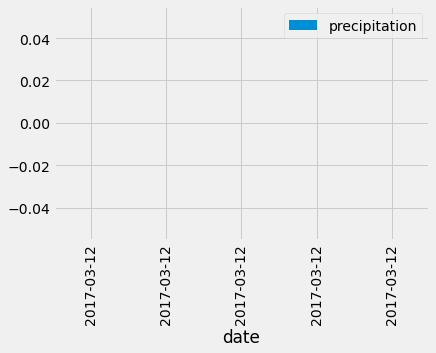

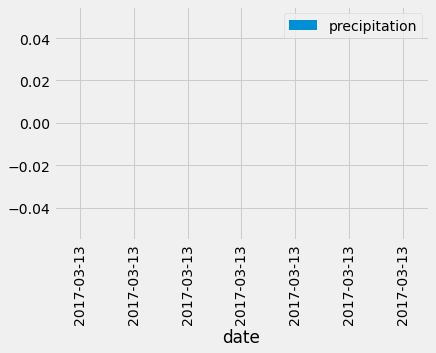

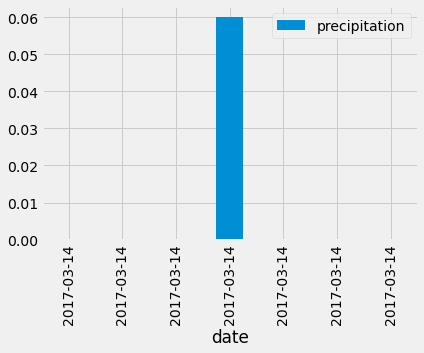

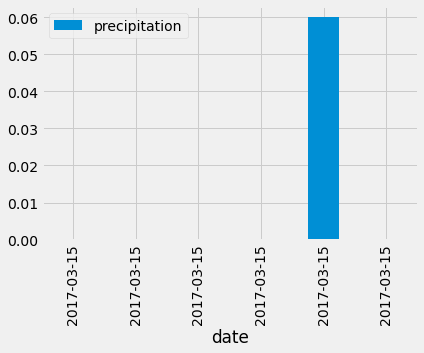

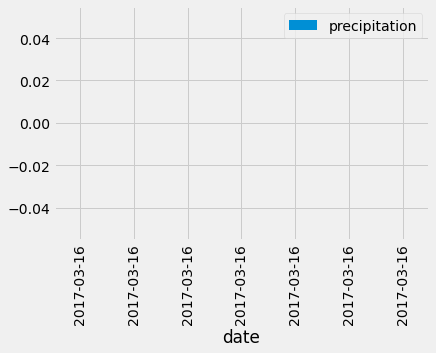

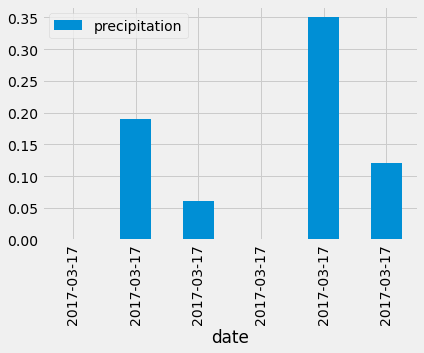

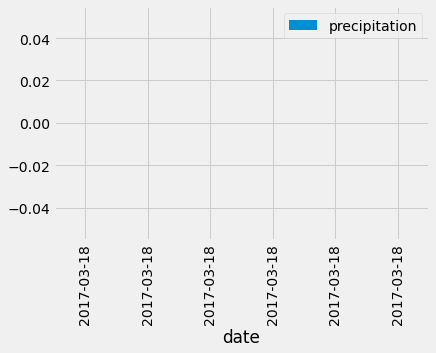

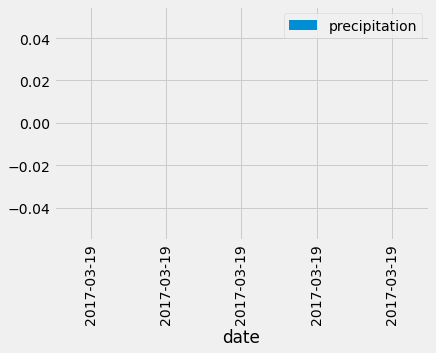

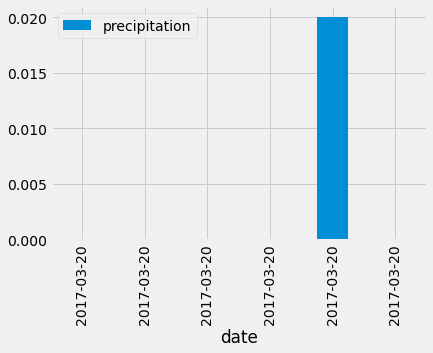

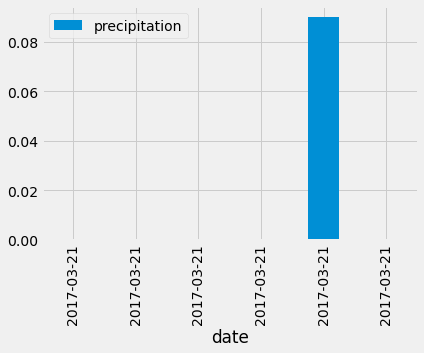

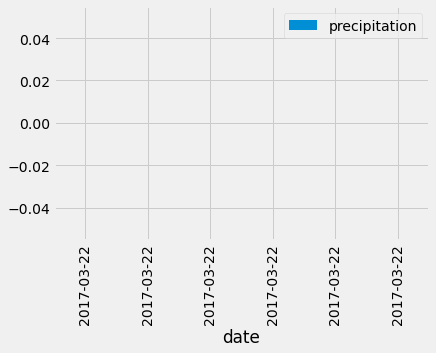

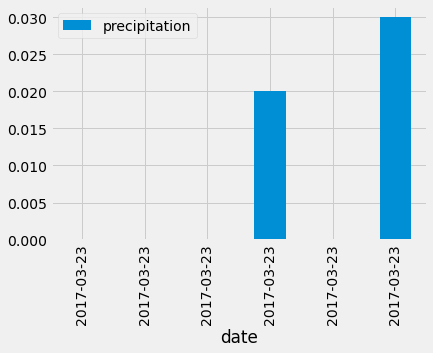

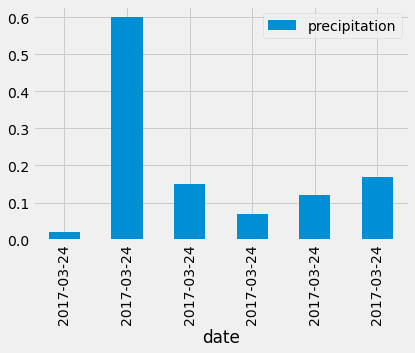

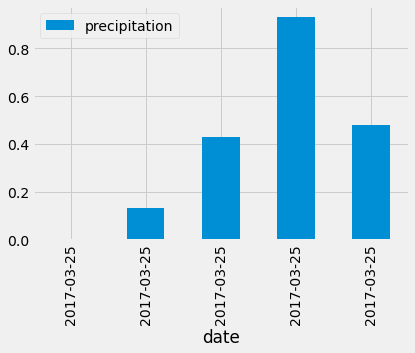

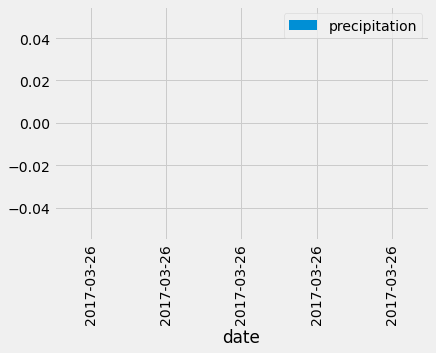

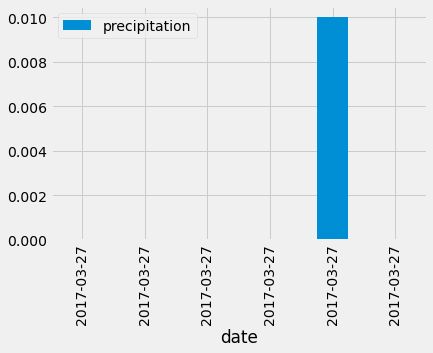

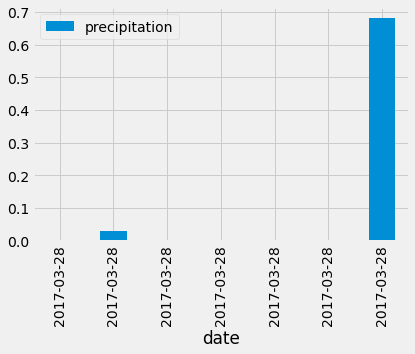

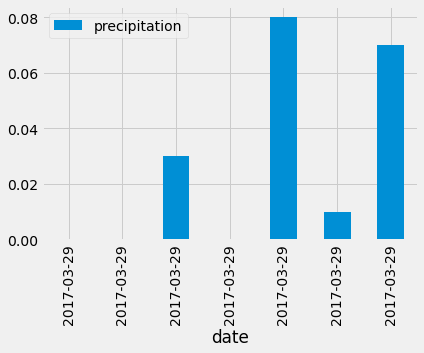

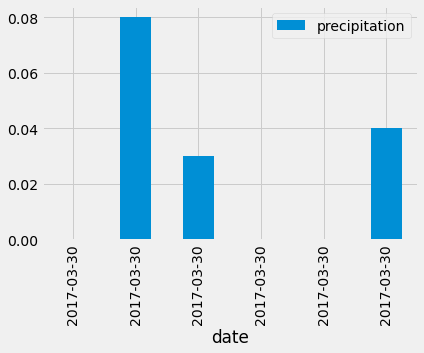

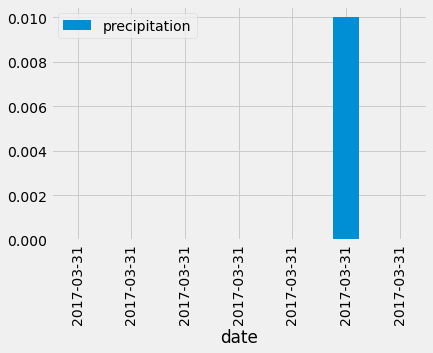

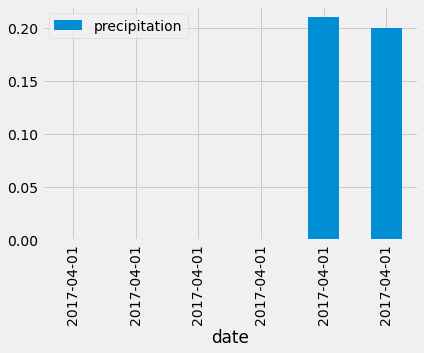

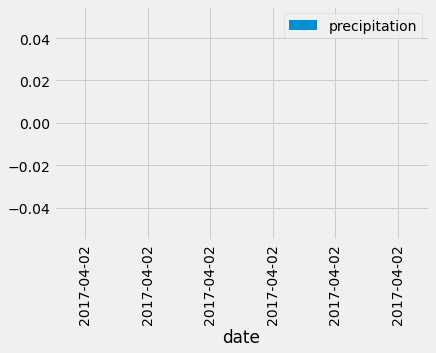

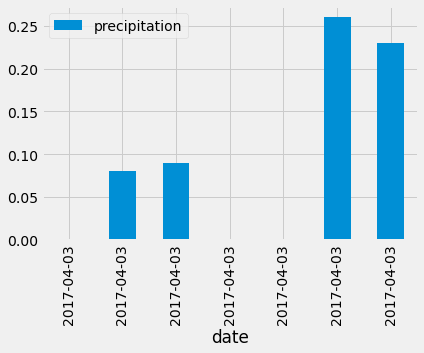

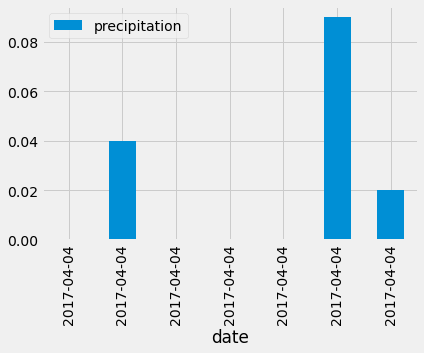

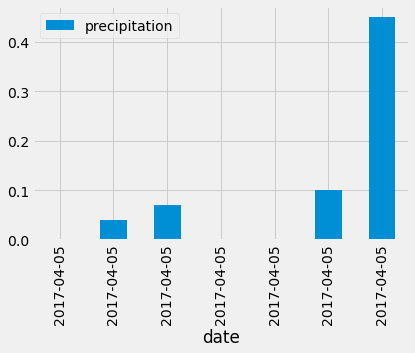

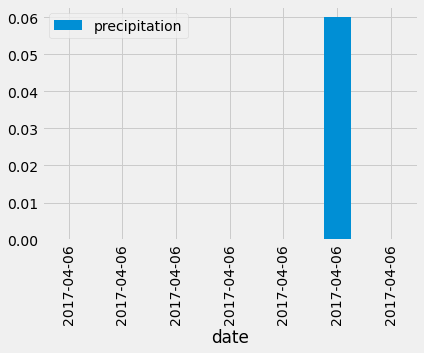

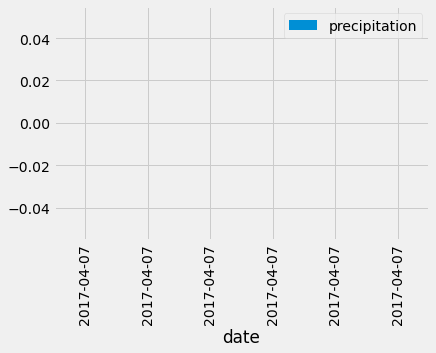

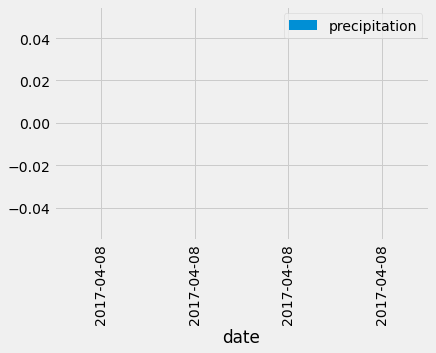

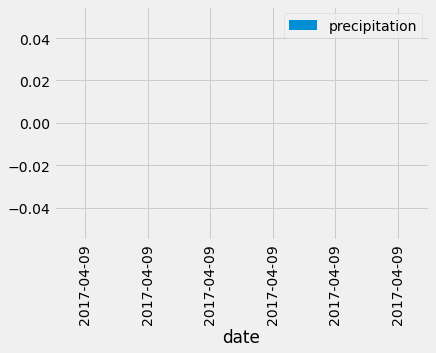

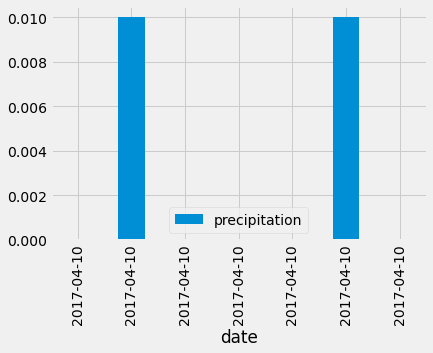

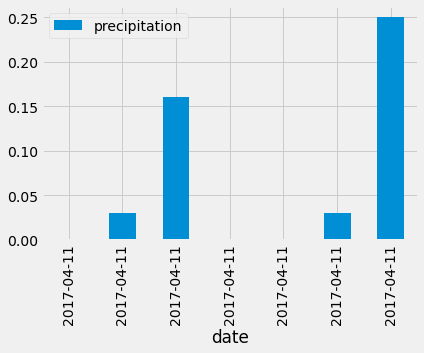

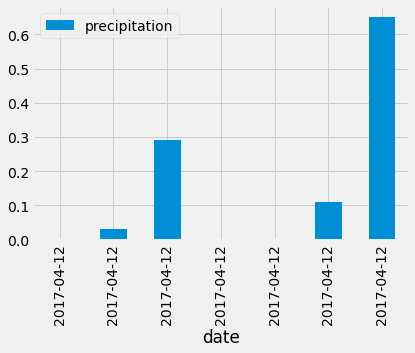

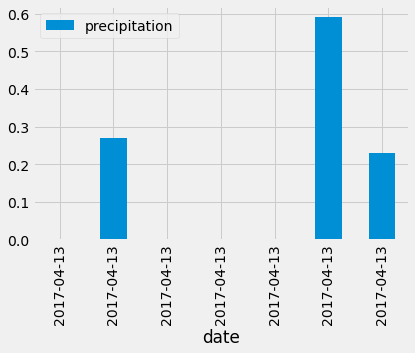

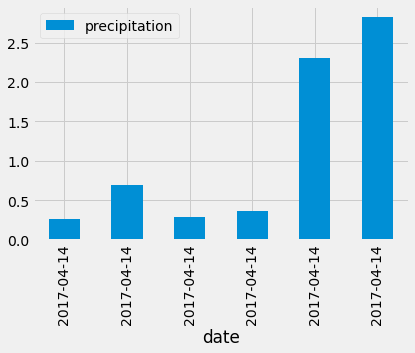

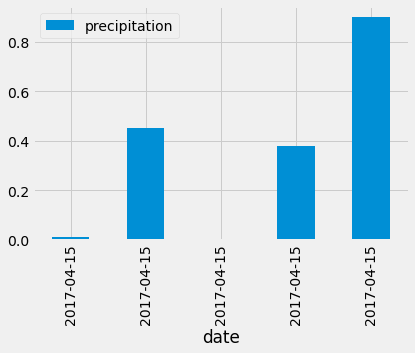

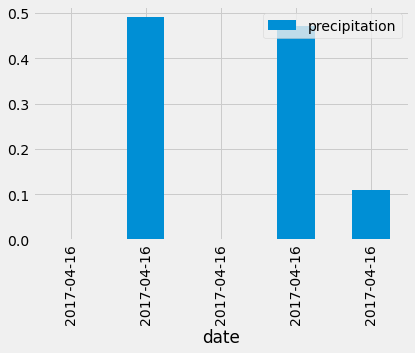

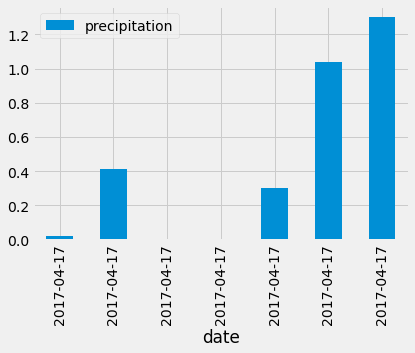

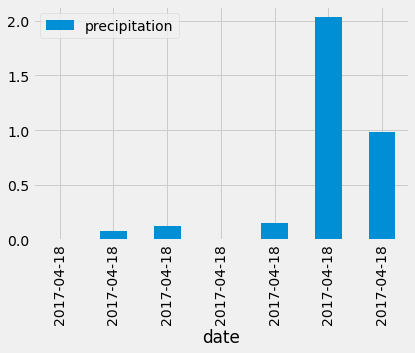

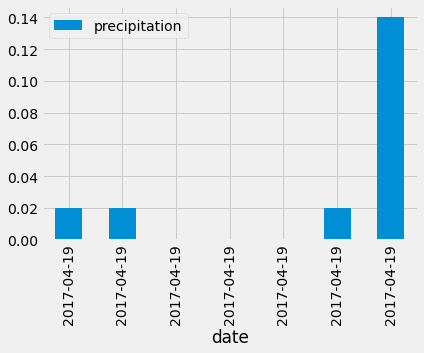

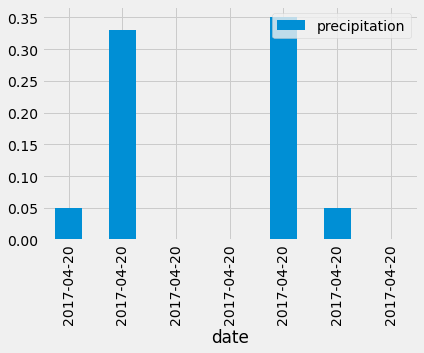

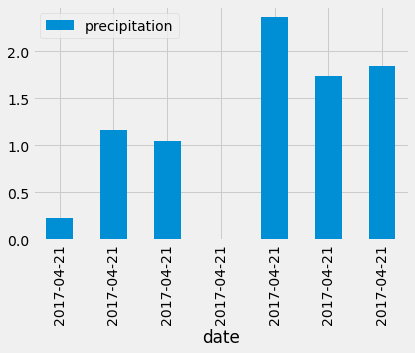

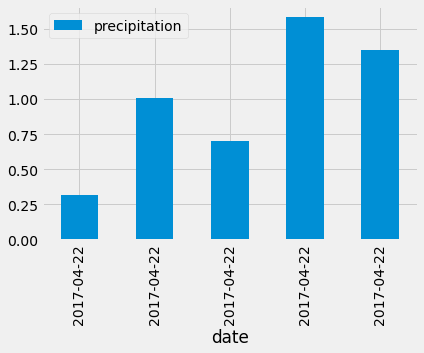

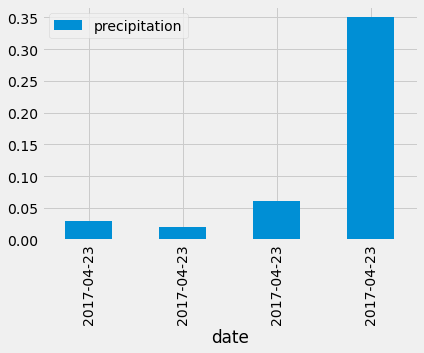

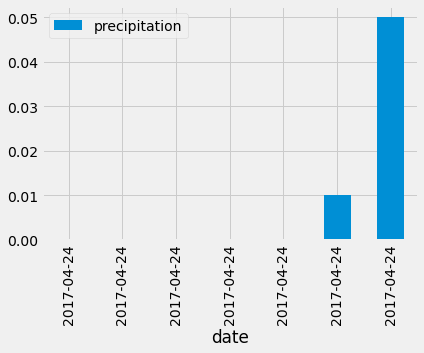

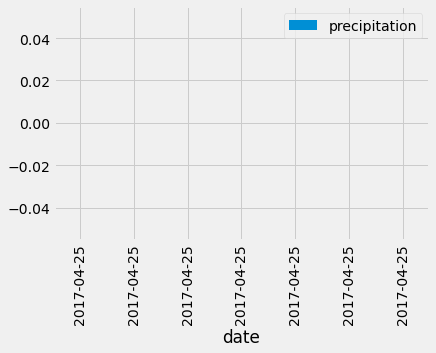

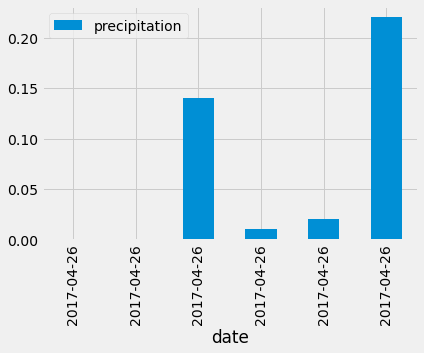

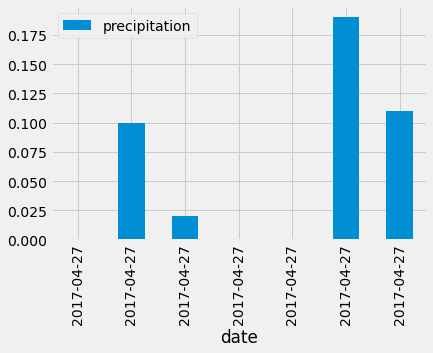

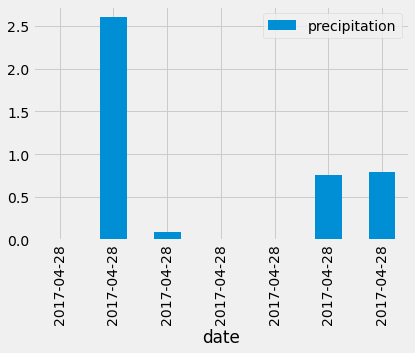

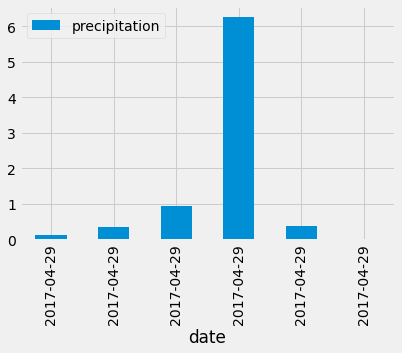

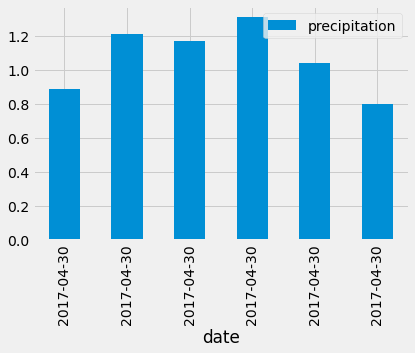

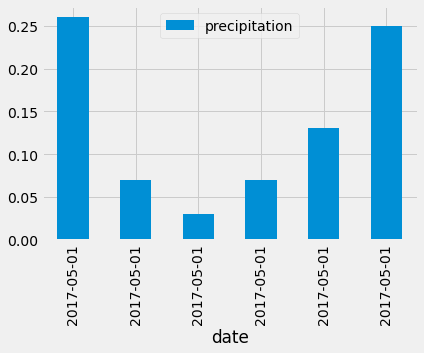

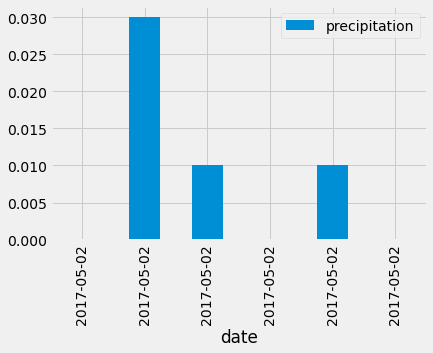

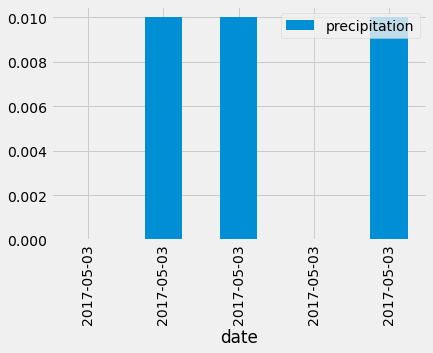

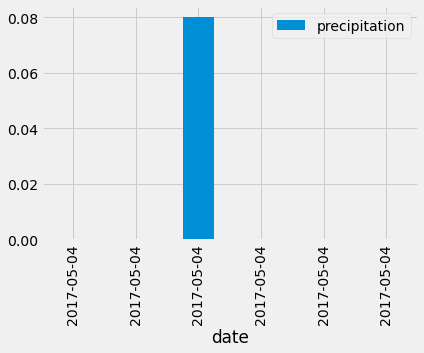

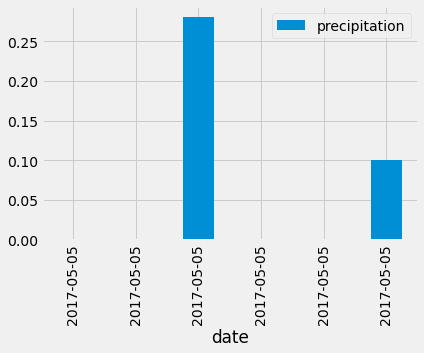

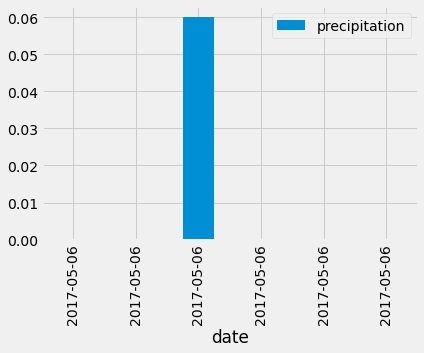

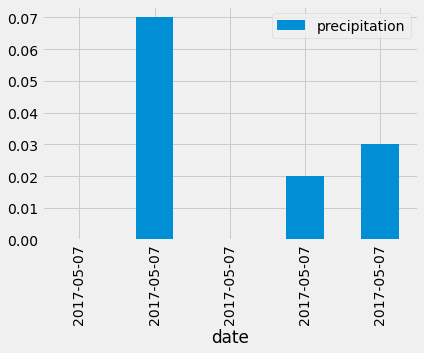

In [ ]:
prcp_data.plot.bar()

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()